# Overcoming Catastrophic Forgetting

https://arxiv.org/abs/1612.00796

## Mnist first then Fmnist

In [1]:
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

2024-05-19 02:19:50.824395: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2024-05-19 02:19:52.114590: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2024-05-19 02:19:52.115315: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2024-05-19 02:19:52.190048: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:65:00.0 name: Quadro RTX 5000 computeCapability: 7.5
coreClock: 1.815GHz coreCount: 48 deviceMemorySize: 15.74GiB deviceMemoryBandwidth: 417.29GiB/s
2024-05-19 02:19:52.190102: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2024-05-19 02:19:52.191961: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2024-

In [2]:
import numpy as np
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.regularizers import Regularizer

#tf.compat.v1.disable_eager_execution()

def computer_fisher(model, imgset, num_sample=30):
    f_accum = []
    for i in range(len(model.weights)):
        f_accum.append(np.zeros(K.int_shape(model.weights[i])))
    f_accum = np.array(f_accum)
    for j in range(num_sample):
        img_index = np.random.randint(imgset.shape[0])
        for m in range(len(model.weights)):                           
            grads = K.gradients(K.log(model.output), model.weights)[m]
            result = K.function([model.input], [grads])
            f_accum[m] += np.square(result([np.expand_dims(imgset[img_index], 0)])[0])
    f_accum /= num_sample
    return f_accum

def ecomputer_fisher(model, imgset, num_sample=30):
    f_accum = []
    for i in range(len(model.weights)):
        f_accum.append(tf.zeros(model.weights[i].shape))
    f_accum = np.array(f_accum)
    for x,y in imgset:
        for m in range(len(model.weights)):
            with tf.GradientTape() as tape:                
                y_preds=tf.math.log(WGN(x))
            grads = tape.gradient(y_preds, model.weights)[m]
            f_accum[m] += tf.square(grads[0])
    f_accum /= len(imgset)
    return f_accum

class ewc_reg(Regularizer):
    def __init__(self, fisher, prior_weights, Lambda=0.1):
        self.fisher = fisher
        self.prior_weights = prior_weights
        self.Lambda = Lambda

    def __call__(self, x):
        regularization = 0.
        regularization += self.Lambda * K.sum(self.fisher * K.square(x - self.prior_weights))
        return regularization

    def get_config(self):
        return {'Lambda': float(self.Lambda)}

2024-05-19 02:19:53.156222: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-19 02:19:53.157119: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2024-05-19 02:19:53.157755: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:65:00.0 name: Quadro RTX 5000 computeCapability: 7.5
coreClock: 1.815GHz coreCount: 48 deviceMemorySize: 15.74GiB deviceMemoryBandwidth: 417.29GiB/s
2024-05-19 02:19:53.157784: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2024-05-19 02:19:53.157820: I tensorflow/stream_executor/platform/de

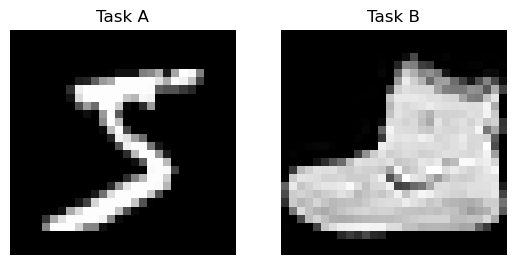

In [3]:
from tensorflow.keras.layers import Dense
from tensorflow.keras.datasets import mnist, fashion_mnist
from tensorflow.keras.models import Sequential
import numpy as np
import matplotlib.pyplot as plt

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

# convert class vectors to binary class matrices
y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)

a = np.zeros((len(y_train),1))
b = np.zeros((len(y_test),1))

for i in range(10):
    y_train = np.hstack((y_train, a))
    y_test = np.hstack((y_test, b))

# Original MNIST for Task A
x_train = x_train.reshape((-1, 784))
x_test = x_test.reshape((-1, 784))

# fmnist for Task B
(x_train1, y_train1), (x_test1, y_test1) = fashion_mnist.load_data()
x_train1 = x_train1.astype('float32')
x_test1 = x_test1.astype('float32')
x_train1 /= 255
x_test1 /= 255

x_train1 = x_train1.reshape((-1, 784))
x_test1 = x_test1.reshape((-1, 784))

# convert class vectors to binary class matrices
y_train1 = tf.keras.utils.to_categorical(y_train1, 10)
y_test1 = tf.keras.utils.to_categorical(y_test1, 10)

for i in range(10):
    y_train1 = np.hstack((a, y_train1))
    y_test1 = np.hstack((b, y_test1))

train_dataset = tf.data.Dataset.from_tensor_slices(
    (x_train.reshape(60000, 784).astype("float32") / 255, y_train.reshape(60000, 20))
)
test_dataset = tf.data.Dataset.from_tensor_slices(
    (x_test.reshape(10000, 784).astype("float32") / 255, y_test.reshape(10000, 20))
)

train_dataset1 = tf.data.Dataset.from_tensor_slices(
    (x_train1.reshape(60000, 784).astype("float32") / 255, y_train1.reshape(60000, 20))
)
test_dataset1 = tf.data.Dataset.from_tensor_slices(
    (x_test1.reshape(10000, 784).astype("float32") / 255, y_test1.reshape(10000, 20))
)

train_dataset = train_dataset.shuffle(buffer_size=60000).batch(1)
test_dataset = test_dataset.shuffle(buffer_size=10000).batch(1)
train_dataset1 = train_dataset1.shuffle(buffer_size=60000).batch(1)
test_dataset1 = test_dataset1.shuffle(buffer_size=10000).batch(1)

# Display three Tasks Dataset images
plt.figure()
plt.subplot(1, 2, 1)
plt.imshow(x_train[0].reshape((28, 28)), cmap='gray')
plt.title('Task A')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(x_train1[0].reshape((28, 28)), cmap='gray')
plt.title('Task B')
plt.axis('off')
plt.show()



In [4]:
abx_train = np.concatenate((x_train, x_train1), axis=0)
aby_train = np.concatenate((y_train, y_train1), axis=0)
abx_test = np.concatenate((x_test, x_test1), axis=0)
aby_test = np.concatenate((y_test, y_test1), axis=0)

abtrain_dataset = tf.data.Dataset.from_tensor_slices(
    (abx_train.reshape(120000, 784).astype("float32") / 255, aby_train.reshape(120000, 20))
)
abtest_dataset = tf.data.Dataset.from_tensor_slices(
    (abx_test.reshape(20000, 784).astype("float32") / 255, aby_test.reshape(20000, 20))
)
abtrain_dataset = abtrain_dataset.shuffle(buffer_size=120000).batch(1)
abtest_dataset = abtest_dataset.shuffle(buffer_size=20000).batch(1)

In [5]:
import tensorflow as tf
from tensorflow import keras 

In [6]:
import numpy as np

input_dim = 784
classes = 20

main_network = keras.Sequential(
    [
        keras.layers.Dense(128, activation=tf.nn.relu),
        keras.layers.Dense(classes),
    ]
)

for layer in main_network.layers:
    layer.built = True

# number of weight coefficients to generate
num_weights_to_generate = (classes * 128 + classes) + (128 * input_dim + 128)

# hypernetwork that generates the weights of the `main_network.
WGN = keras.Sequential(
    [
        keras.layers.Dense(128, activation=tf.nn.relu),
        keras.layers.Dense(num_weights_to_generate, activation=tf.nn.tanh),
    ]
)

In [7]:
# Loss and optimizer.
loss_fn = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
acc_fn = tf.keras.metrics.CategoricalAccuracy()
optimizer = tf.keras.optimizers.Adam()

#@tf.function
def train_step(x, y, WGN, step, ada = 1):
    with tf.GradientTape() as tape:
        if step == 0:
            weights_init = tf.random.uniform((1,num_weights_to_generate))
            # Reshape them to the expected shapes for w and b for the outer model.
            # Layer 0 kernel.
            start_index = 0
            w0_shape = (input_dim, 128)
            w0_coeffs = weights_init[:, start_index : start_index + np.prod(w0_shape)]
            w0 = tf.reshape(w0_coeffs, w0_shape)
            start_index += np.prod(w0_shape)
            # Layer 0 bias.
            b0_shape = (128,)
            b0_coeffs = weights_init[:, start_index : start_index + np.prod(b0_shape)]
            b0 = tf.reshape(b0_coeffs, b0_shape)
            start_index += np.prod(b0_shape)
            # Layer 1 kernel.
            w1_shape = (128, classes)
            w1_coeffs = weights_init[:, start_index : start_index + np.prod(w1_shape)]
            w1 = tf.reshape(w1_coeffs, w1_shape)
            start_index += np.prod(w1_shape)
            # Layer 1 bias.
            b1_shape = (classes,)
            b1_coeffs = weights_init[:, start_index : start_index + np.prod(b1_shape)]
            b1 = tf.reshape(b1_coeffs, b1_shape)
            start_index += np.prod(b1_shape)

            main_network.layers[0].kernel = w0
            main_network.layers[0].bias = b0
            main_network.layers[1].kernel = w1
            main_network.layers[1].bias = b1
        
        # Predict weights for the outer model.
        weights_pred = WGN(x)

        # Reshape them to the expected shapes for w and b for the outer model.
        # Layer 0 kernel.
        start_index = 0
        w0_shape = (input_dim, 128)
        w0_coeffs = weights_pred[:, start_index : start_index + np.prod(w0_shape)]
        w0 = tf.reshape(w0_coeffs, w0_shape)
        start_index += np.prod(w0_shape)
        # Layer 0 bias.
        b0_shape = (128,)
        b0_coeffs = weights_pred[:, start_index : start_index + np.prod(b0_shape)]
        b0 = tf.reshape(b0_coeffs, b0_shape)
        start_index += np.prod(b0_shape)
        # Layer 1 kernel.
        w1_shape = (128, classes)
        w1_coeffs = weights_pred[:, start_index : start_index + np.prod(w1_shape)]
        w1 = tf.reshape(w1_coeffs, w1_shape)
        start_index += np.prod(w1_shape)
        # Layer 1 bias.
        b1_shape = (classes,)
        b1_coeffs = weights_pred[:, start_index : start_index + np.prod(b1_shape)]
        b1 = tf.reshape(b1_coeffs, b1_shape)
        start_index += np.prod(b1_shape)

        
        # Set the weight predictions as the weight variables on the outer model.
        main_network.layers[0].kernel = (1-ada)*main_network.layers[0].kernel + ada*w0
        main_network.layers[0].bias = (1-ada)*main_network.layers[0].bias + ada*b0
        main_network.layers[1].kernel = (1-ada)*main_network.layers[1].kernel + ada*w1
        main_network.layers[1].bias = (1-ada)*main_network.layers[1].bias + ada*b1
        
        # Inference on the outer model.
        preds = main_network(x)
        loss = loss_fn(y, preds)

    # update accuracy.
    acc_fn.update_state(y, preds)
    train_acc = acc_fn.result()
    # Train only inner model.    
    grads = tape.gradient(loss, WGN.trainable_weights)
    optimizer.apply_gradients(zip(grads, WGN.trainable_weights))
    return loss, train_acc


In [8]:
tstloss_fn = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
tstacc_fn = tf.keras.metrics.CategoricalAccuracy()

from tensorflow.keras import backend as K

#@tf.function
def test_step(x, y, WGN, ada = 1):
    # Predict weights for the outer model.
    weights_pred = WGN(x)

    # Reshape them to the expected shapes for w and b for the outer model.
    # Layer 0 kernel.
    start_index = 0
    w0_shape = (input_dim, 128)
    w0_coeffs = weights_pred[:, start_index : start_index + np.prod(w0_shape)]
    w0 = tf.reshape(w0_coeffs, w0_shape)
    start_index += np.prod(w0_shape)
    # Layer 0 bias.
    b0_shape = (128,)
    b0_coeffs = weights_pred[:, start_index : start_index + np.prod(b0_shape)]
    b0 = tf.reshape(b0_coeffs, b0_shape)
    start_index += np.prod(b0_shape)
    # Layer 1 kernel.
    w1_shape = (128, classes)
    w1_coeffs = weights_pred[:, start_index : start_index + np.prod(w1_shape)]
    w1 = tf.reshape(w1_coeffs, w1_shape)
    start_index += np.prod(w1_shape)
    # Layer 1 bias.
    b1_shape = (classes,)
    b1_coeffs = weights_pred[:, start_index : start_index + np.prod(b1_shape)]
    b1 = tf.reshape(b1_coeffs, b1_shape)
    start_index += np.prod(b1_shape)

    # Set the weight predictions as the weight variables on the outer model.
    main_network.layers[0].kernel = (1-ada)*main_network.layers[0].kernel + ada*w0
    main_network.layers[0].bias = (1-ada)*main_network.layers[0].bias + ada*b0
    main_network.layers[1].kernel = (1-ada)*main_network.layers[1].kernel + ada*w1
    main_network.layers[1].bias = (1-ada)*main_network.layers[1].bias + ada*b1

    # Inference on the outer model.
    preds = main_network(x)
    loss = tstloss_fn(y, preds)

    # here X is param 1 (input) and the function returns output from layers
    # Inference on the outer model.
    get_layer_output = K.function(
      [main_network.layers[0].input], # param 1 will be treated as layer[0].output
      [main_network.layers[1].output]) 

    lyr = get_layer_output(x)

    # update accuracy.
    tstacc_fn.update_state(y, preds)
    test_acc = tstacc_fn.result()
 
    return loss, test_acc, preds, lyr, weights_pred

In [9]:
losses = []  # Keep track of the losses over time.
train_accs = []
test_accs = []

#main_network.compile(loss=loss_fn, optimizer=optimizer, metrics=acc_fn)
epochs = 10
for i in range(epochs):
    for step, (x, y) in enumerate(train_dataset):
        loss, train_acc = train_step(x, y, WGN, step)
    
        # Logging.
        losses.append(float(loss))
        train_accs.append(train_acc)
        if step%10000 == 0:
            print("Epochs:", i, "Step in progress:", step)            
    
    acc_fn.reset_states()
    #evaluate on testdata
    for tstep, (xt, yt) in enumerate(test_dataset):
        test_loss, test_acc, preds, _, _ = test_step(xt, yt, WGN)
        test_accs.append(test_acc)
    tstacc_fn.reset_states()
    
    print("Epochs:", i, "Step:", step, "Train Loss:", sum(losses) / len(losses), "Train Acc:", train_acc, "Test Acc:", test_acc)

2024-05-19 02:19:54.929064: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10


Epochs: 0 Step in progress: 0
Epochs: 0 Step in progress: 10000
Epochs: 0 Step in progress: 20000
Epochs: 0 Step in progress: 30000
Epochs: 0 Step in progress: 40000
Epochs: 0 Step in progress: 50000
Epochs: 0 Step: 59999 Train Loss: 0.4596768382705291 Train Acc: tf.Tensor(0.8563333, shape=(), dtype=float32) Test Acc: tf.Tensor(0.9257, shape=(), dtype=float32)
Epochs: 1 Step in progress: 0
Epochs: 1 Step in progress: 10000
Epochs: 1 Step in progress: 20000
Epochs: 1 Step in progress: 30000
Epochs: 1 Step in progress: 40000
Epochs: 1 Step in progress: 50000
Epochs: 1 Step: 59999 Train Loss: 0.33763651977719444 Train Acc: tf.Tensor(0.93488336, shape=(), dtype=float32) Test Acc: tf.Tensor(0.9495, shape=(), dtype=float32)
Epochs: 2 Step in progress: 0
Epochs: 2 Step in progress: 10000
Epochs: 2 Step in progress: 20000
Epochs: 2 Step in progress: 30000
Epochs: 2 Step in progress: 40000
Epochs: 2 Step in progress: 50000
Epochs: 2 Step: 59999 Train Loss: 0.27875745899903775 Train Acc: tf.Tens

In [10]:

#savemodel
WGN.save("EWGNcc_MnistA.h5")
with open('EWGNcc_MnistA_losses.npy', 'wb') as f:
    np.save(f, np.array(losses))
    
with open('EWGNcc_MnistA_tracc.npy', 'wb') as f:
    np.save(f, np.array(train_accs))
with open('EWGNcc_MnistA_tstacc.npy', 'wb') as f:
    np.save(f, np.array(test_accs))

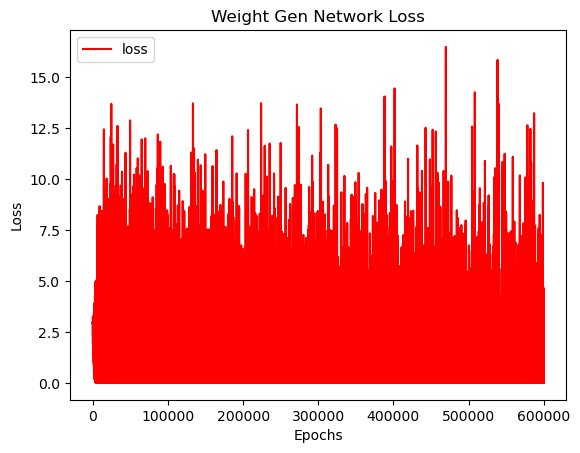

In [11]:
import matplotlib.pyplot as plt

plt.plot(losses, 'r', label='loss')
plt.title('Weight Gen Network Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

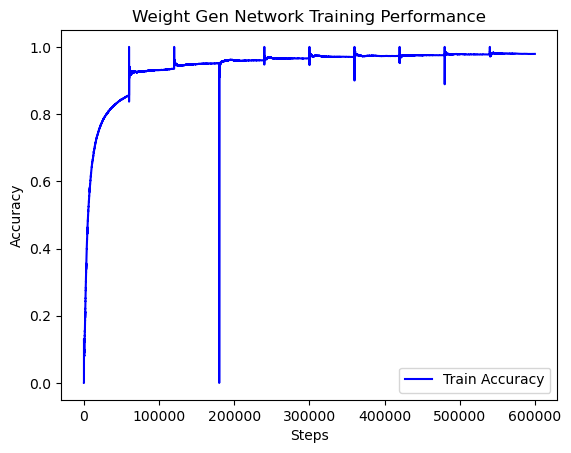

In [12]:
import matplotlib.pyplot as plt

plt.plot(train_accs, 'b', label='Train Accuracy')
plt.title('Weight Gen Network Training Performance')
plt.xlabel('Steps')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

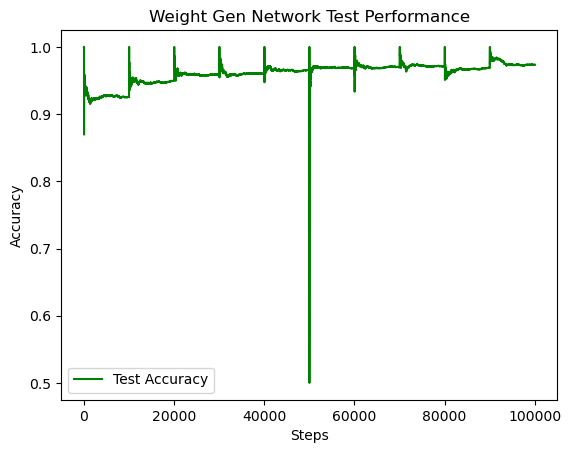

In [13]:
plt.plot(test_accs, 'g', label='Test Accuracy')
plt.title('Weight Gen Network Test Performance')
plt.xlabel('Steps')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [14]:
WGN(x_train[0].reshape(1,784))
WGN.load_weights("EWGNcc_MnistA.h5")

In [15]:
# Compute the Fisher Information for each parameter in Task A
print('Processing Fisher Information...')
I = ecomputer_fisher(WGN, train_dataset)
print('Processing Finish!')

Processing Fisher Information...


/tmp/ipykernel_16728/3952594402.py:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  f_accum = np.array(f_accum)


Processing Finish!


In [16]:
# Task B penalty training
# WGN that generates the weights of the `main_network.
WGN_ewcB = keras.Sequential(
    [
        keras.layers.Dense(128, activation=tf.nn.relu, kernel_regularizer=ewc_reg(I[0], WGN.weights[0]),
                 bias_regularizer=ewc_reg(I[1], WGN.weights[1])),
        keras.layers.Dense(num_weights_to_generate, activation=tf.nn.tanh, kernel_regularizer=ewc_reg(I[2], WGN.weights[2]),
                 bias_regularizer=ewc_reg(I[3], WGN.weights[3])),
    ]
)

In [17]:
WGN_ewcB(x_train[0].reshape(1,784))
WGN_ewcB.load_weights('EWGNcc_MnistA.h5')

losses = []  # Keep track of the losses over time.
train_accs = []
test_accs = []

#main_network.compile(loss=loss_fn, optimizer=optimizer, metrics=acc_fn)
epochs = 10
for i in range(epochs):
    for step, (x, y) in enumerate(train_dataset1):
        loss, train_acc = train_step(x, y, WGN_ewcB, step)
    
        # Logging.
        losses.append(float(loss))
        train_accs.append(train_acc)
        if step%10000 == 0:
                print("Epochs:", i, "Step in progress:", step)
    
    acc_fn.reset_states()
    #evaluate on testdata
    for tstep, (xt, yt) in enumerate(test_dataset1):
        test_loss, test_acc, preds, _, _ = test_step(xt, yt, WGN_ewcB)
        test_accs.append(test_acc)
    tstacc_fn.reset_states()
    
    print("Epochs:", i, "Step:", step, "Train Loss:", sum(losses) / len(losses), "Train Acc:", train_acc, "Test Acc:", test_acc)

Epochs: 0 Step in progress: 0
Epochs: 0 Step in progress: 10000
Epochs: 0 Step in progress: 20000
Epochs: 0 Step in progress: 30000
Epochs: 0 Step in progress: 40000
Epochs: 0 Step in progress: 50000
Epochs: 0 Step: 59999 Train Loss: 0.7544560555781293 Train Acc: tf.Tensor(0.7588, shape=(), dtype=float32) Test Acc: tf.Tensor(0.8078, shape=(), dtype=float32)
Epochs: 1 Step in progress: 0
Epochs: 1 Step in progress: 10000
Epochs: 1 Step in progress: 20000
Epochs: 1 Step in progress: 30000
Epochs: 1 Step in progress: 40000
Epochs: 1 Step in progress: 50000
Epochs: 1 Step: 59999 Train Loss: 0.6121570623338557 Train Acc: tf.Tensor(0.83141667, shape=(), dtype=float32) Test Acc: tf.Tensor(0.8315, shape=(), dtype=float32)
Epochs: 2 Step in progress: 0
Epochs: 2 Step in progress: 10000
Epochs: 2 Step in progress: 20000
Epochs: 2 Step in progress: 30000
Epochs: 2 Step in progress: 40000
Epochs: 2 Step in progress: 50000
Epochs: 2 Step: 59999 Train Loss: 0.5470419002265436 Train Acc: tf.Tensor(0.

In [18]:
#savemodel
WGN_ewcB.save("EWGNcc_FMnistB.h5")
with open('EWGNcc_FMnistB_losses.npy', 'wb') as f:
    np.save(f, np.array(losses))
    
with open('EWGNcc_FMnistB_tracc.npy', 'wb') as f:
    np.save(f, np.array(train_accs))
with open('EWGNcc_FMnistB_tstacc.npy', 'wb') as f:
    np.save(f, np.array(test_accs))

In [19]:
# Task B no penalty training
# WGN that generates the weights of the `main_network.
WGN_NoP_B = keras.Sequential(
    [
        keras.layers.Dense(128, activation=tf.nn.relu),
        keras.layers.Dense(num_weights_to_generate, activation=tf.nn.tanh),
    ]
)

In [20]:
WGN_NoP_B(x_train[0].reshape(1,784))
WGN_NoP_B.load_weights('EWGNcc_MnistA.h5')

losses = []  # Keep track of the losses over time.
train_accs = []
test_accs = []

#main_network.compile(loss=loss_fn, optimizer=optimizer, metrics=acc_fn)
epochs = 10
for i in range(epochs):
    for step, (x, y) in enumerate(train_dataset1):
        loss, train_acc = train_step(x, y, WGN_NoP_B, step)
    
        # Logging.
        losses.append(float(loss))
        train_accs.append(train_acc)
        if step%10000 == 0:
                print("Epochs:", i, "Step in progress:", step)            
    
    acc_fn.reset_states()
    #evaluate on testdata
    for tstep, (xt, yt) in enumerate(test_dataset1):
        test_loss, test_acc, preds, _, _ = test_step(xt, yt, WGN_NoP_B)
        test_accs.append(test_acc)
    tstacc_fn.reset_states()
    
    print("Epochs:", i, "Step:", step, "Train Loss:", sum(losses) / len(losses), "Train Acc:", train_acc, "Test Acc:", test_acc)

Epochs: 0 Step in progress: 0
Epochs: 0 Step in progress: 10000
Epochs: 0 Step in progress: 20000
Epochs: 0 Step in progress: 30000
Epochs: 0 Step in progress: 40000
Epochs: 0 Step in progress: 50000
Epochs: 0 Step: 59999 Train Loss: 0.8246091715602144 Train Acc: tf.Tensor(0.7213167, shape=(), dtype=float32) Test Acc: tf.Tensor(0.8086, shape=(), dtype=float32)
Epochs: 1 Step in progress: 0
Epochs: 1 Step in progress: 10000
Epochs: 1 Step in progress: 20000
Epochs: 1 Step in progress: 30000
Epochs: 1 Step in progress: 40000
Epochs: 1 Step in progress: 50000
Epochs: 1 Step: 59999 Train Loss: 0.64047698248624 Train Acc: tf.Tensor(0.8355333, shape=(), dtype=float32) Test Acc: tf.Tensor(0.8309, shape=(), dtype=float32)
Epochs: 2 Step in progress: 0
Epochs: 2 Step in progress: 10000
Epochs: 2 Step in progress: 20000
Epochs: 2 Step in progress: 30000
Epochs: 2 Step in progress: 40000
Epochs: 2 Step in progress: 50000
Epochs: 2 Step: 59999 Train Loss: 0.5624194997561603 Train Acc: tf.Tensor(0.

In [21]:
#savemodel
WGN_NoP_B.save("EWGNcc_FMnistNoB.h5")
with open('EWGNcc_FMnistNoB_losses.npy', 'wb') as f:
    np.save(f, np.array(losses))
    
with open('EWGNcc_FMnistNoB_tracc.npy', 'wb') as f:
    np.save(f, np.array(train_accs))
with open('EWGNcc_FMnistNoB_tstacc.npy', 'wb') as f:
    np.save(f, np.array(test_accs))

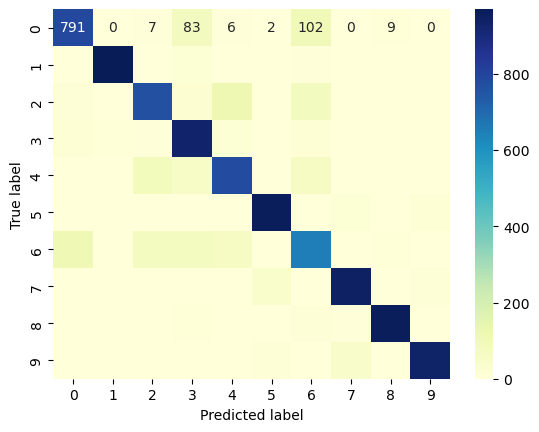

In [40]:
import pandas as pd
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix

#Current Task B Perfomrance Evals
dataset = test_dataset1
preds = []
weight_preds = []
lyrpreds = []
y_test_true = []
x_test_true = []

for tstep, (xt, yt) in enumerate(dataset):
    x_test_true.append(xt)
    y_test_true.append(yt)
    _, _, pred, lyr, weight_pred = test_step(xt, yt, WGN_ewcB)
    preds.append(pred)
    weight_preds.append(weight_pred)
    lyrpreds.append(lyr)
tstacc_fn.reset_states()

y_test_arg = np.argmax(y_test_true, axis=-1)
y_pred = np.argmax(preds, axis=-1)
B_EWC = accuracy_score(y_test_arg, y_pred )

#confusionmat
cm = confusion_matrix(y_test_arg, y_pred)

plt.figure()
sns.heatmap(cm, fmt = 'd' , cmap="YlGnBu",  annot=True)

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()



In [23]:
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

avg = None

acs = accuracy_score(y_test_arg, y_pred)
pcs = precision_score(y_test_arg, y_pred, average = avg)
rcs = recall_score(y_test_arg, y_pred, average = avg)
fcs = f1_score(y_test_arg, y_pred, average = avg)

prfs = precision_recall_fscore_support(y_test_arg, y_pred, average = avg)

print("\nAverging = ", avg, "\naccuracy = ", acs, "\nprecision = ", pcs, "\nrecall = ", rcs, "\nf1 score = ", fcs)
print("\nclasswise metrics = ", prfs)

avg = "micro"

acs = accuracy_score(y_test_arg, y_pred)
pcs = precision_score(y_test_arg, y_pred, average = avg)
rcs = recall_score(y_test_arg, y_pred, average = avg)
fcs = f1_score(y_test_arg, y_pred, average = avg)

prfs = precision_recall_fscore_support(y_test_arg, y_pred, average = avg)

print("\nAverging = ", avg, "\n\naccuracy = ", acs, "\nprecision = ", pcs, "\nrecall = ", rcs, "\nf1 score = ", fcs)
print("\nclasswise metrics = ", prfs)

avg = "macro"

acs = accuracy_score(y_test_arg, y_pred)
pcs = precision_score(y_test_arg, y_pred, average = avg)
rcs = recall_score(y_test_arg, y_pred, average = avg)
fcs = f1_score(y_test_arg, y_pred, average = avg)

prfs = precision_recall_fscore_support(y_test_arg, y_pred, average = avg)

print("\nAverging = ", avg, "\naccuracy = ", acs, "\nprecision = ", pcs, "\nrecall = ", rcs, "\nf1 score = ", fcs)
print("\nclasswise metrics = ", prfs)

avg = "weighted"

acs = accuracy_score(y_test_arg, y_pred)
pcs = precision_score(y_test_arg, y_pred, average = avg)
rcs = recall_score(y_test_arg, y_pred, average = avg)
fcs = f1_score(y_test_arg, y_pred, average = avg)

prfs = precision_recall_fscore_support(y_test_arg, y_pred, average = avg)

print("\nAverging = ", avg, "\naccuracy = ", acs, "\nprecision = ", pcs, "\nrecall = ", rcs, "\nf1 score = ", fcs)
print("\nclasswise metrics = ", prfs)


Averging =  None 
accuracy =  0.8694 
precision =  [0.84148936 0.98477157 0.80631579 0.77481234 0.78356713 0.94400786
 0.69518717 0.92661448 0.97461929 0.96900826] 
recall =  [0.791 0.97  0.766 0.929 0.782 0.961 0.65  0.947 0.96  0.938] 
f1 score =  [0.81546392 0.97732997 0.78564103 0.84492951 0.78278278 0.95242815
 0.67183463 0.93669634 0.96725441 0.95325203]

classwise metrics =  (array([0.84148936, 0.98477157, 0.80631579, 0.77481234, 0.78356713,
       0.94400786, 0.69518717, 0.92661448, 0.97461929, 0.96900826]), array([0.791, 0.97 , 0.766, 0.929, 0.782, 0.961, 0.65 , 0.947, 0.96 ,
       0.938]), array([0.81546392, 0.97732997, 0.78564103, 0.84492951, 0.78278278,
       0.95242815, 0.67183463, 0.93669634, 0.96725441, 0.95325203]), array([1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000]))

Averging =  micro 

accuracy =  0.8694 
precision =  0.8694 
recall =  0.8694 
f1 score =  0.8694

classwise metrics =  (0.8694, 0.8694, 0.8694, None)

Averging =  macro 
accuracy =  0.

In [25]:
import umap
import umap.plot

sz=10000

imgs = np.array(weight_preds).reshape(sz,num_weights_to_generate)
labels = np.argmax(np.array(preds).reshape(sz,20), axis=1)

mapper = umap.UMAP().fit(imgs)
umap.plot.points(mapper, labels=labels)

<Axes: >

<Axes: >

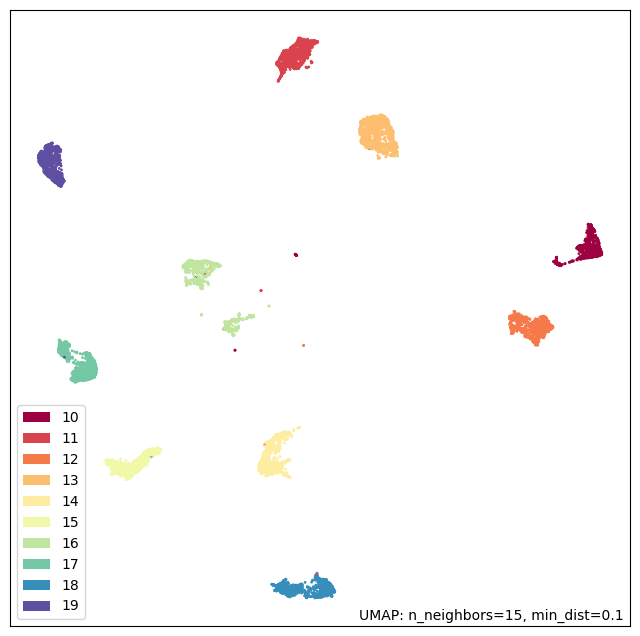

In [26]:
imgs = np.array(weight_preds).reshape(sz,num_weights_to_generate)
labels = np.argmax(np.array(preds).reshape(sz,20), axis=1)

mapper = umap.UMAP().fit(imgs, labels)
umap.plot.points(mapper, labels=labels)

<Axes: >

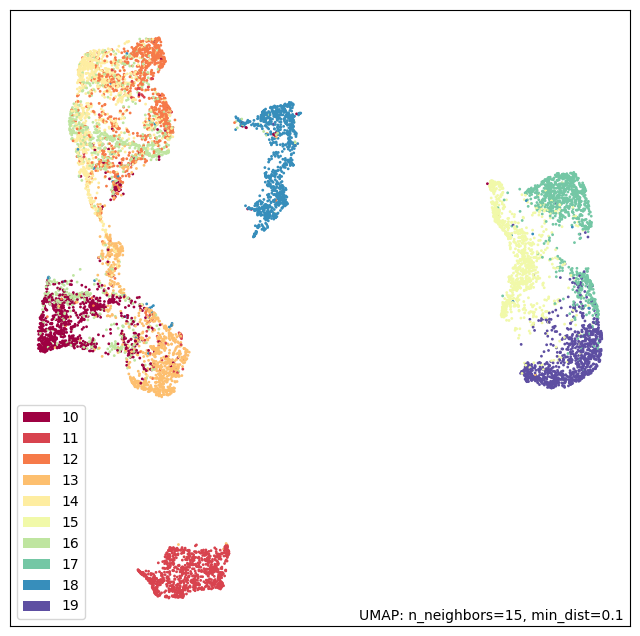

In [32]:
imgs = np.array(weight_preds).reshape(sz,num_weights_to_generate)
labels = np.argmax(np.asarray(y_test_true).reshape(sz,20), axis=1)

mapper = umap.UMAP().fit(imgs)
umap.plot.points(mapper, labels=labels)

In [33]:
imgs = np.array(weight_preds).reshape(sz,num_weights_to_generate)
labels = np.argmax(np.asarray(y_test_true).reshape(sz,20), axis=1)

mapper = umap.UMAP().fit(imgs, labels)
umap.plot.points(mapper, labels=labels)

<Axes: >

In [34]:
imgs = np.array(lyrpreds).reshape(sz,20)
labels = np.argmax(np.array(preds).reshape(sz,20), axis=1)

mapper = umap.UMAP().fit(imgs)
umap.plot.points(mapper, labels=labels)

<Axes: >

<Axes: >

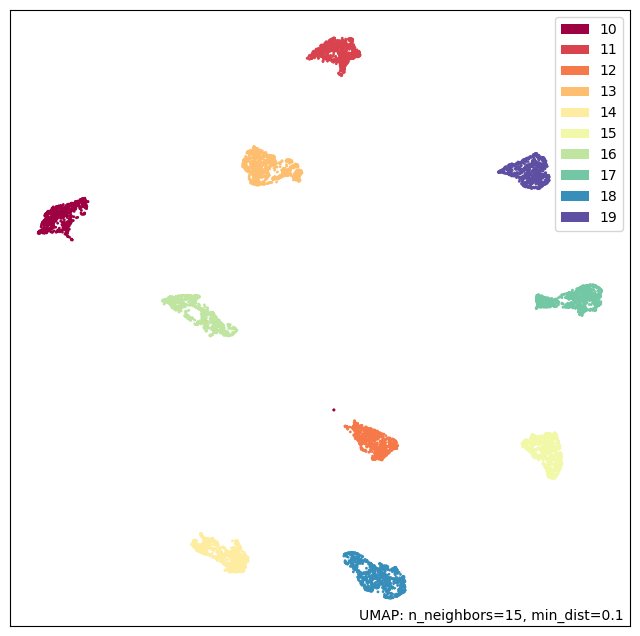

In [36]:
imgs = np.array(lyrpreds).reshape(sz,20)
labels = np.argmax(np.array(preds).reshape(sz,20), axis=1)

mapper = umap.UMAP().fit(imgs, labels)
umap.plot.points(mapper, labels=labels)

<Axes: >

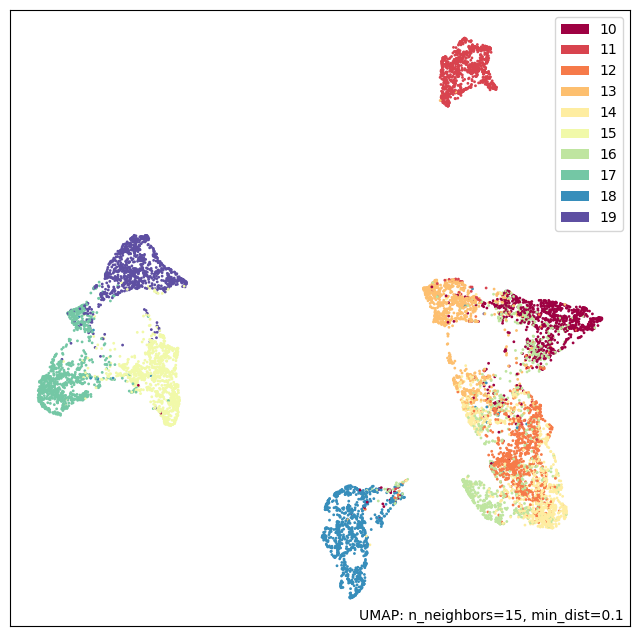

In [37]:
imgs = np.array(lyrpreds).reshape(sz,20)
labels = np.argmax(np.asarray(y_test_true).reshape(sz,20), axis=1)

mapper = umap.UMAP().fit(imgs)
umap.plot.points(mapper, labels=labels)

<Axes: >

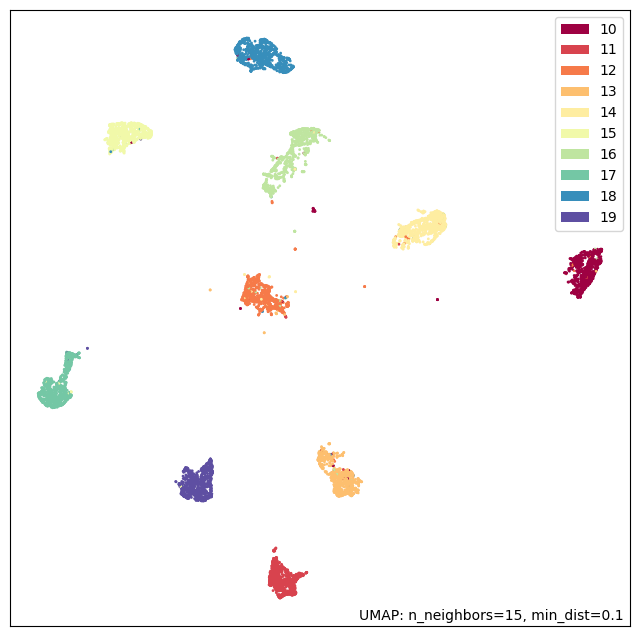

In [39]:
imgs = np.array(lyrpreds).reshape(sz,20)
labels = np.argmax(np.asarray(y_test_true).reshape(sz,20), axis=1)

mapper = umap.UMAP().fit(imgs, labels)
umap.plot.points(mapper, labels=labels)

In [41]:
imgs = np.asarray(x_test_true).reshape(sz, 784).astype("float32") / 255
labels = np.argmax(np.array(preds).reshape(sz,20), axis=1)
mapper = umap.UMAP().fit(imgs)
umap.plot.points(mapper, labels=labels)

<Axes: >

<Axes: >

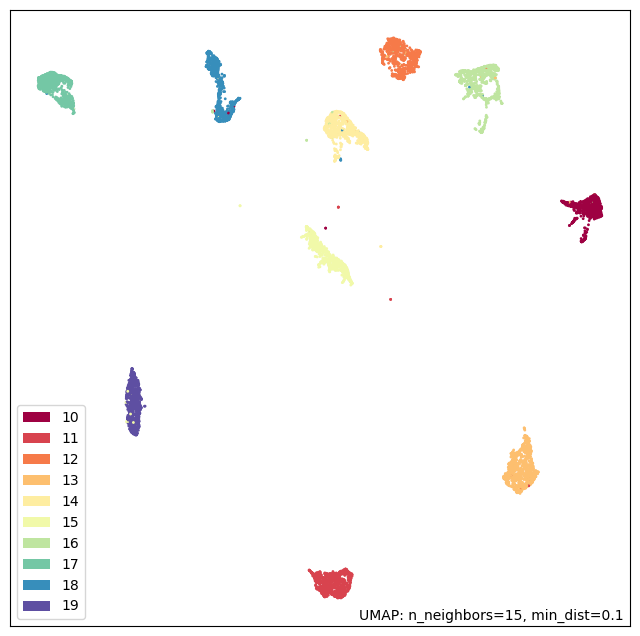

In [42]:
imgs = np.asarray(x_test_true).reshape(sz, 784).astype("float32") / 255
labels = np.argmax(np.array(preds).reshape(sz,20), axis=1)
mapper = umap.UMAP().fit(imgs, labels)
umap.plot.points(mapper, labels=labels)

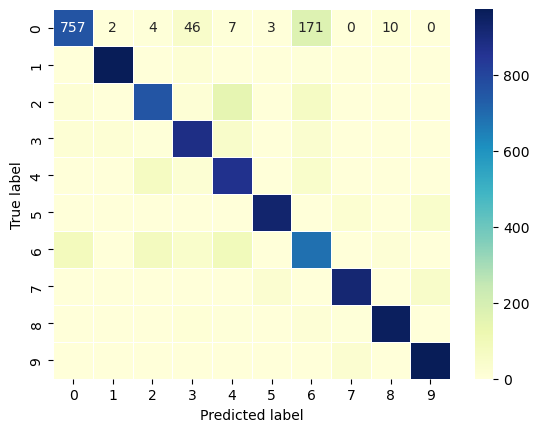

In [43]:
#Current Task B Perfomrance Evals
#Current Task B Perfomrance Evals
dataset = test_dataset1
preds = []
weight_preds = []
lyrpreds = []
y_test_true = []
x_test_true = []

for tstep, (xt, yt) in enumerate(dataset):
    x_test_true.append(xt)
    y_test_true.append(yt)
    _, _, pred, lyr, weight_pred = test_step(xt, yt, WGN_NoP_B)
    preds.append(pred)
    weight_preds.append(weight_pred)
    lyrpreds.append(lyr)
tstacc_fn.reset_states()

y_test_arg = np.argmax(y_test_true, axis=-1)
y_pred = np.argmax(preds, axis=-1)
B_No_P = accuracy_score(y_test_arg, y_pred )

#confusionmat
cm = confusion_matrix(y_test_arg, y_pred)

plt.figure()
sns.heatmap(cm, fmt = 'd' , cmap="YlGnBu",  annot=True, linewidths=.5)

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [44]:
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

avg = None

acs = accuracy_score(y_test_arg, y_pred)
pcs = precision_score(y_test_arg, y_pred, average = avg)
rcs = recall_score(y_test_arg, y_pred, average = avg)
fcs = f1_score(y_test_arg, y_pred, average = avg)

prfs = precision_recall_fscore_support(y_test_arg, y_pred, average = avg)

print("\nAverging = ", avg, "\naccuracy = ", acs, "\nprecision = ", pcs, "\nrecall = ", rcs, "\nf1 score = ", fcs)
print("\nclasswise metrics = ", prfs)

avg = "micro"

acs = accuracy_score(y_test_arg, y_pred)
pcs = precision_score(y_test_arg, y_pred, average = avg)
rcs = recall_score(y_test_arg, y_pred, average = avg)
fcs = f1_score(y_test_arg, y_pred, average = avg)

prfs = precision_recall_fscore_support(y_test_arg, y_pred, average = avg)

print("\nAverging = ", avg, "\n\naccuracy = ", acs, "\nprecision = ", pcs, "\nrecall = ", rcs, "\nf1 score = ", fcs)
print("\nclasswise metrics = ", prfs)

avg = "macro"

acs = accuracy_score(y_test_arg, y_pred)
pcs = precision_score(y_test_arg, y_pred, average = avg)
rcs = recall_score(y_test_arg, y_pred, average = avg)
fcs = f1_score(y_test_arg, y_pred, average = avg)

prfs = precision_recall_fscore_support(y_test_arg, y_pred, average = avg)

print("\nAverging = ", avg, "\naccuracy = ", acs, "\nprecision = ", pcs, "\nrecall = ", rcs, "\nf1 score = ", fcs)
print("\nclasswise metrics = ", prfs)

avg = "weighted"

acs = accuracy_score(y_test_arg, y_pred)
pcs = precision_score(y_test_arg, y_pred, average = avg)
rcs = recall_score(y_test_arg, y_pred, average = avg)
fcs = f1_score(y_test_arg, y_pred, average = avg)

prfs = precision_recall_fscore_support(y_test_arg, y_pred, average = avg)

print("\nAverging = ", avg, "\naccuracy = ", acs, "\nprecision = ", pcs, "\nrecall = ", rcs, "\nf1 score = ", fcs)
print("\nclasswise metrics = ", prfs)


Averging =  None 
accuracy =  0.8686 
precision =  [0.86120592 0.97492477 0.82065217 0.8540856  0.73927959 0.9607438
 0.67620928 0.94250513 0.96969697 0.90985915] 
recall =  [0.757 0.972 0.755 0.878 0.862 0.93  0.685 0.918 0.96  0.969] 
f1 score =  [0.80574774 0.97346019 0.78645833 0.86587771 0.79593721 0.94512195
 0.68057625 0.93009119 0.96482412 0.93849879]

classwise metrics =  (array([0.86120592, 0.97492477, 0.82065217, 0.8540856 , 0.73927959,
       0.9607438 , 0.67620928, 0.94250513, 0.96969697, 0.90985915]), array([0.757, 0.972, 0.755, 0.878, 0.862, 0.93 , 0.685, 0.918, 0.96 ,
       0.969]), array([0.80574774, 0.97346019, 0.78645833, 0.86587771, 0.79593721,
       0.94512195, 0.68057625, 0.93009119, 0.96482412, 0.93849879]), array([1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000]))

Averging =  micro 

accuracy =  0.8686 
precision =  0.8686 
recall =  0.8686 
f1 score =  0.8686

classwise metrics =  (0.8686, 0.8686, 0.8686, None)

Averging =  macro 
accuracy =  0.8

<Axes: >

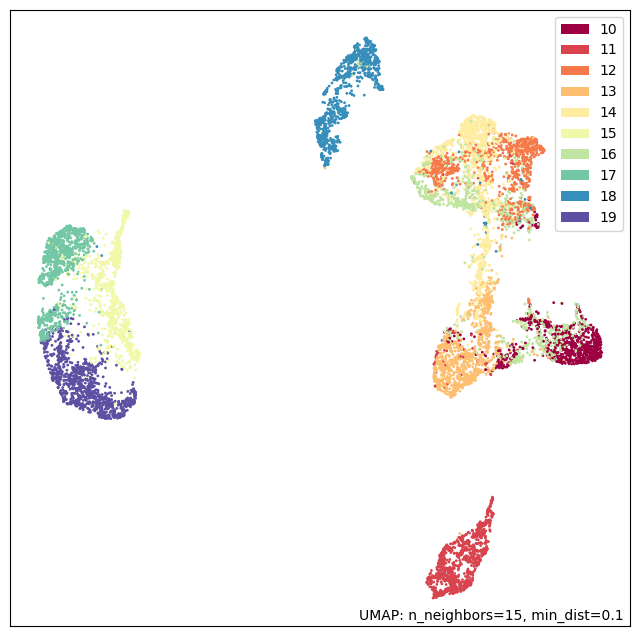

In [45]:
import umap
import umap.plot

sz=10000

imgs = np.array(weight_preds).reshape(sz,num_weights_to_generate)
labels = np.argmax(np.array(preds).reshape(sz,20), axis=1)

mapper = umap.UMAP().fit(imgs)
umap.plot.points(mapper, labels=labels)

<Axes: >

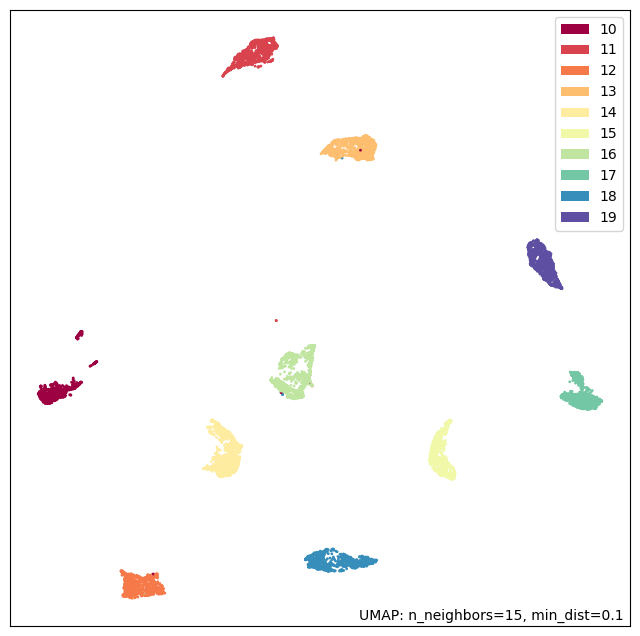

In [46]:
imgs = np.array(weight_preds).reshape(sz,num_weights_to_generate)
labels = np.argmax(np.array(preds).reshape(sz,20), axis=1)

mapper = umap.UMAP().fit(imgs, labels)
umap.plot.points(mapper, labels=labels)

In [47]:
imgs = np.array(weight_preds).reshape(sz,num_weights_to_generate)
labels = np.argmax(np.asarray(y_test_true).reshape(sz,20), axis=1)

mapper = umap.UMAP().fit(imgs)
umap.plot.points(mapper, labels=labels)

<Axes: >

<Axes: >

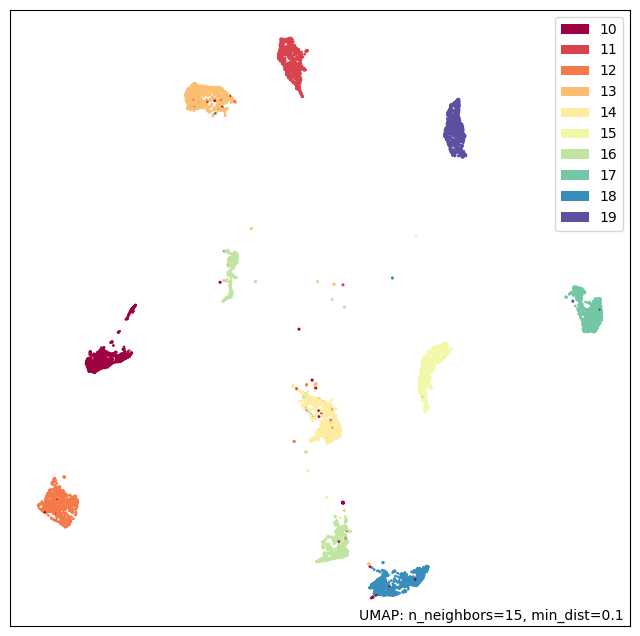

In [48]:
imgs = np.array(weight_preds).reshape(sz,num_weights_to_generate)
labels = np.argmax(np.asarray(y_test_true).reshape(sz,20), axis=1)

mapper = umap.UMAP().fit(imgs, labels)
umap.plot.points(mapper, labels=labels)

In [49]:
imgs = np.array(lyrpreds).reshape(sz,20)
labels = np.argmax(np.array(preds).reshape(sz,20), axis=1)

mapper = umap.UMAP().fit(imgs)
umap.plot.points(mapper, labels=labels)

<Axes: >

<Axes: >

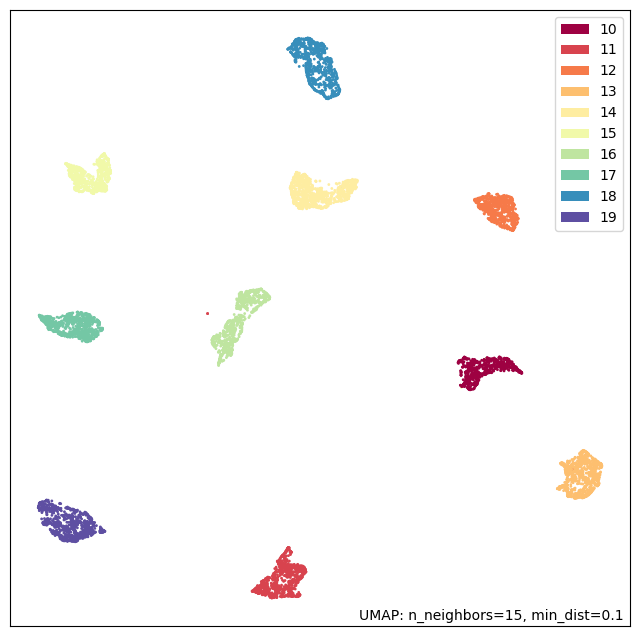

In [50]:
imgs = np.array(lyrpreds).reshape(sz,20)
labels = np.argmax(np.array(preds).reshape(sz,20), axis=1)

mapper = umap.UMAP().fit(imgs, labels)
umap.plot.points(mapper, labels=labels)

In [51]:
imgs = np.array(lyrpreds).reshape(sz,20)
labels = np.argmax(np.asarray(y_test_true).reshape(sz,20), axis=1)

mapper = umap.UMAP().fit(imgs)
umap.plot.points(mapper, labels=labels)

<Axes: >

<Axes: >

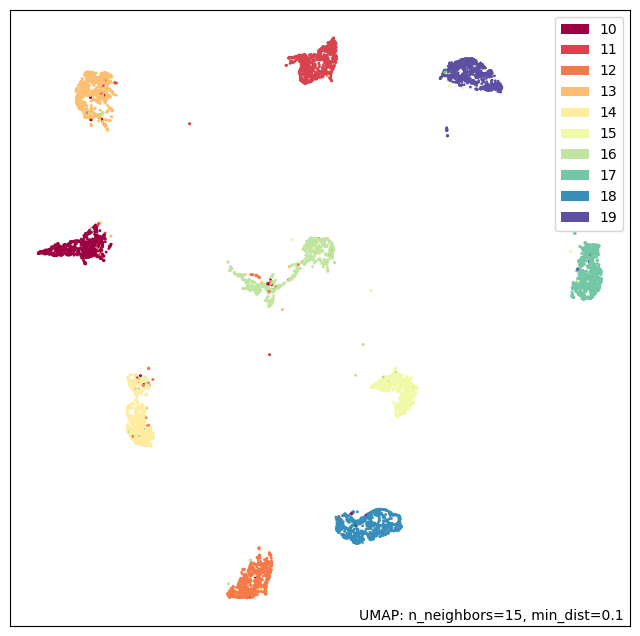

In [52]:
imgs = np.array(lyrpreds).reshape(sz,20)
labels = np.argmax(np.asarray(y_test_true).reshape(sz,20), axis=1)

mapper = umap.UMAP().fit(imgs, labels)
umap.plot.points(mapper, labels=labels)

<Axes: >

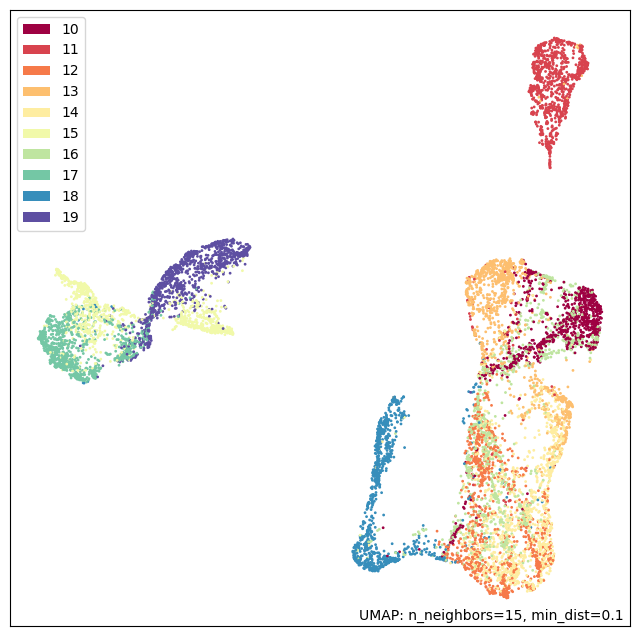

In [53]:
imgs = np.asarray(x_test_true).reshape(sz, 784).astype("float32") / 255
labels = np.argmax(np.array(preds).reshape(sz,20), axis=1)
mapper = umap.UMAP().fit(imgs)
umap.plot.points(mapper, labels=labels)

In [54]:
imgs = np.asarray(x_test_true).reshape(sz, 784).astype("float32") / 255
labels = np.argmax(np.array(preds).reshape(sz,20), axis=1)
mapper = umap.UMAP().fit(imgs, labels)
umap.plot.points(mapper, labels=labels)

<Axes: >

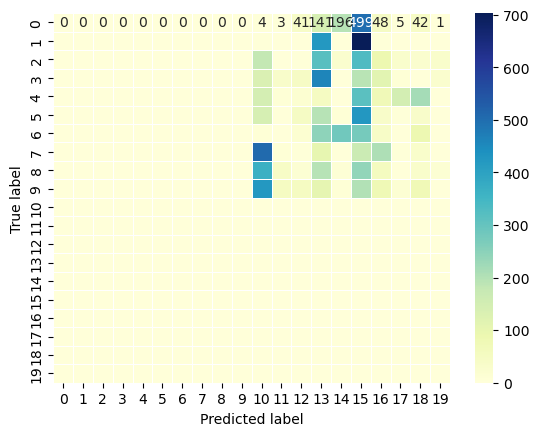

In [55]:
#Previous Task A Perfomrance Evals

dataset = test_dataset
preds = []
weight_preds = []
lyrpreds = []
y_test_true = []
x_test_true = []

for tstep, (xt, yt) in enumerate(dataset):
    x_test_true.append(xt)
    y_test_true.append(yt)
    _, _, pred, lyr, weight_pred = test_step(xt, yt, WGN_ewcB)
    preds.append(pred)
    weight_preds.append(weight_pred)
    lyrpreds.append(lyr)
tstacc_fn.reset_states()

y_test_arg = np.argmax(y_test_true, axis=-1)
y_pred = np.argmax(preds, axis=-1)
A_EWC = accuracy_score(y_test_arg, y_pred )

#confusionmat
y_test_arg = np.argmax(y_test_true, axis=-1)
y_pred = np.argmax(preds, axis=-1)
cm = confusion_matrix(y_test_arg, y_pred)

plt.figure()
sns.heatmap(cm, fmt = 'd' , cmap="YlGnBu",  annot=True, linewidths=.5)

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [56]:
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

avg = None

acs = accuracy_score(y_test_arg, y_pred)
pcs = precision_score(y_test_arg, y_pred, average = avg)
rcs = recall_score(y_test_arg, y_pred, average = avg)
fcs = f1_score(y_test_arg, y_pred, average = avg)

prfs = precision_recall_fscore_support(y_test_arg, y_pred, average = avg)

print("\nAverging = ", avg, "\naccuracy = ", acs, "\nprecision = ", pcs, "\nrecall = ", rcs, "\nf1 score = ", fcs)
print("\nclasswise metrics = ", prfs)

avg = "micro"

acs = accuracy_score(y_test_arg, y_pred)
pcs = precision_score(y_test_arg, y_pred, average = avg)
rcs = recall_score(y_test_arg, y_pred, average = avg)
fcs = f1_score(y_test_arg, y_pred, average = avg)

prfs = precision_recall_fscore_support(y_test_arg, y_pred, average = avg)

print("\nAverging = ", avg, "\n\naccuracy = ", acs, "\nprecision = ", pcs, "\nrecall = ", rcs, "\nf1 score = ", fcs)
print("\nclasswise metrics = ", prfs)

avg = "macro"

acs = accuracy_score(y_test_arg, y_pred)
pcs = precision_score(y_test_arg, y_pred, average = avg)
rcs = recall_score(y_test_arg, y_pred, average = avg)
fcs = f1_score(y_test_arg, y_pred, average = avg)

prfs = precision_recall_fscore_support(y_test_arg, y_pred, average = avg)

print("\nAverging = ", avg, "\naccuracy = ", acs, "\nprecision = ", pcs, "\nrecall = ", rcs, "\nf1 score = ", fcs)
print("\nclasswise metrics = ", prfs)

avg = "weighted"

acs = accuracy_score(y_test_arg, y_pred)
pcs = precision_score(y_test_arg, y_pred, average = avg)
rcs = recall_score(y_test_arg, y_pred, average = avg)
fcs = f1_score(y_test_arg, y_pred, average = avg)

prfs = precision_recall_fscore_support(y_test_arg, y_pred, average = avg)

print("\nAverging = ", avg, "\naccuracy = ", acs, "\nprecision = ", pcs, "\nrecall = ", rcs, "\nf1 score = ", fcs)
print("\nclasswise metrics = ", prfs)


Averging =  None 
accuracy =  0.0 
precision =  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] 
recall =  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] 
f1 score =  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]

classwise metrics =  (array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0.]), array([ 980., 1135., 1032., 1010.,  982.,  892.,  958., 1028.,  974.,
       1009.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.]))

Averging =  micro 

accuracy =  0.0 
precision =  0.0 
recall =  0.0 
f1 score =  0.0

classwise metrics =  (0.0, 0.0, 0.0, None)

Averging =  macro 
accuracy =  0.0 
precision =  0.0 
recall =  0.0 
f1 score =  0.0

classwise metrics =  (0.0, 0.0, 0.0, None)

Averg

/home/shriraj/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/shriraj/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/shriraj/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/shriraj/anacond

<Axes: >

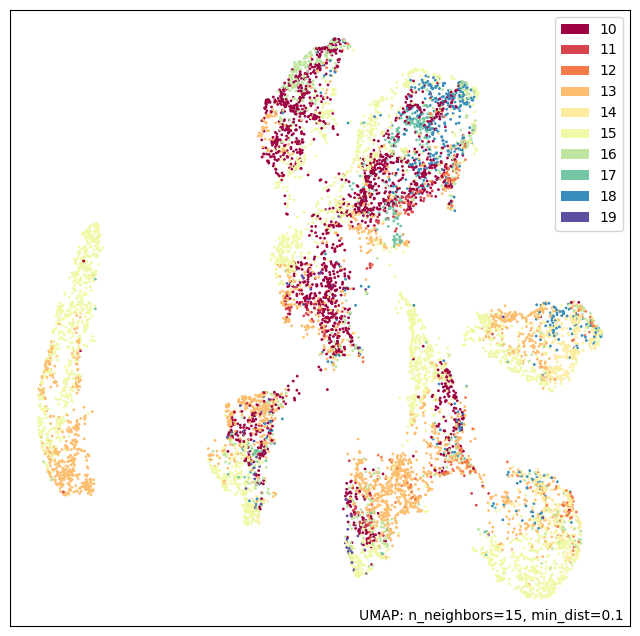

In [57]:
import umap
import umap.plot

sz=10000

imgs = np.array(weight_preds).reshape(sz,num_weights_to_generate)
labels = np.argmax(np.array(preds).reshape(sz,20), axis=1)

mapper = umap.UMAP().fit(imgs)
umap.plot.points(mapper, labels=labels)

<Axes: >

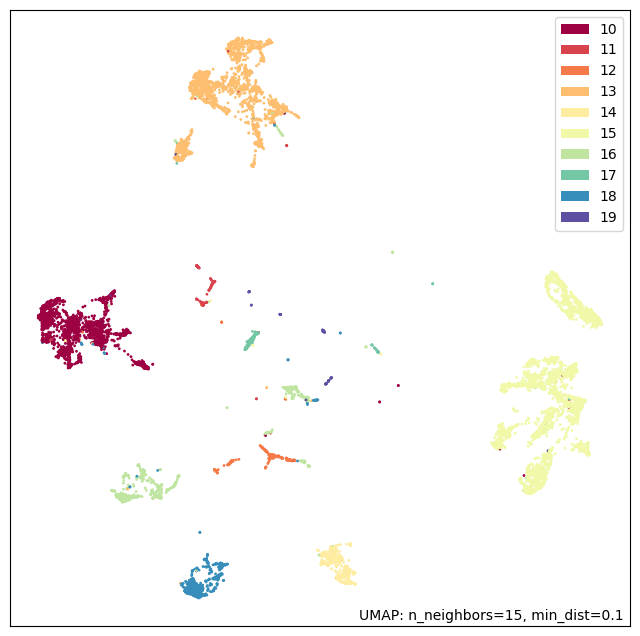

In [58]:
imgs = np.array(weight_preds).reshape(sz,num_weights_to_generate)
labels = np.argmax(np.array(preds).reshape(sz,20), axis=1)

mapper = umap.UMAP().fit(imgs, labels)
umap.plot.points(mapper, labels=labels)

<Axes: >

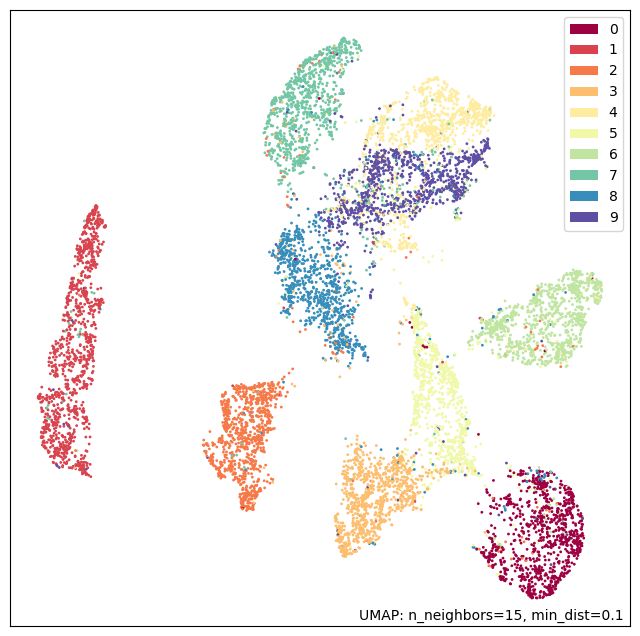

In [59]:
imgs = np.array(weight_preds).reshape(sz,num_weights_to_generate)
labels = np.argmax(np.asarray(y_test_true).reshape(sz,20), axis=1)

mapper = umap.UMAP().fit(imgs)
umap.plot.points(mapper, labels=labels)

In [60]:
imgs = np.array(weight_preds).reshape(sz,num_weights_to_generate)
labels = np.argmax(np.asarray(y_test_true).reshape(sz,20), axis=1)

mapper = umap.UMAP().fit(imgs, labels)
umap.plot.points(mapper, labels=labels)

<Axes: >

<Axes: >

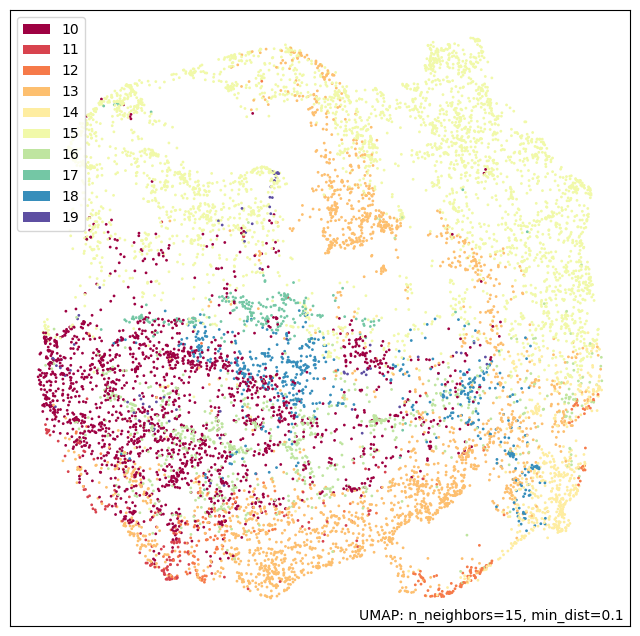

In [61]:
imgs = np.array(lyrpreds).reshape(sz,20)
labels = np.argmax(np.array(preds).reshape(sz,20), axis=1)

mapper = umap.UMAP().fit(imgs)
umap.plot.points(mapper, labels=labels)

<Axes: >

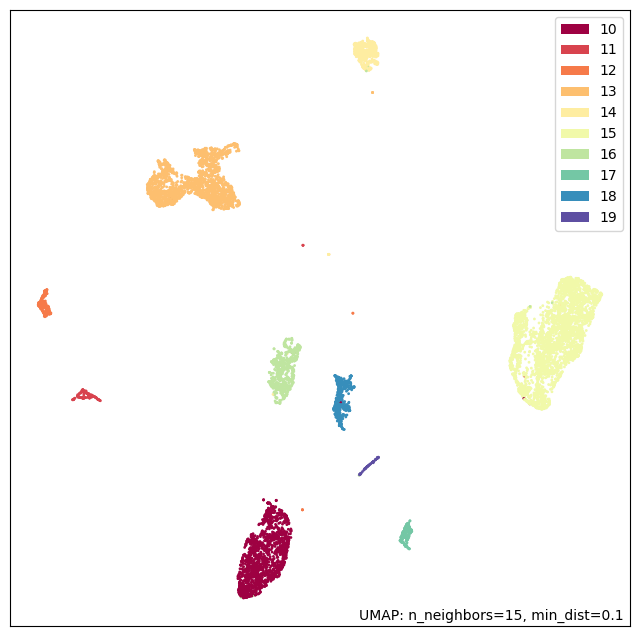

In [62]:
imgs = np.array(lyrpreds).reshape(sz,20)
labels = np.argmax(np.array(preds).reshape(sz,20), axis=1)

mapper = umap.UMAP().fit(imgs, labels)
umap.plot.points(mapper, labels=labels)

<Axes: >

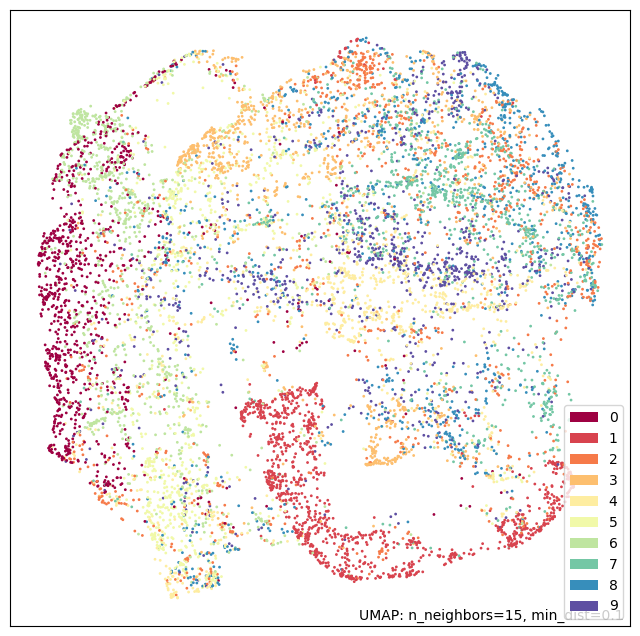

In [63]:
imgs = np.array(lyrpreds).reshape(sz,20)
labels = np.argmax(np.asarray(y_test_true).reshape(sz,20), axis=1)

mapper = umap.UMAP().fit(imgs)
umap.plot.points(mapper, labels=labels)

<Axes: >

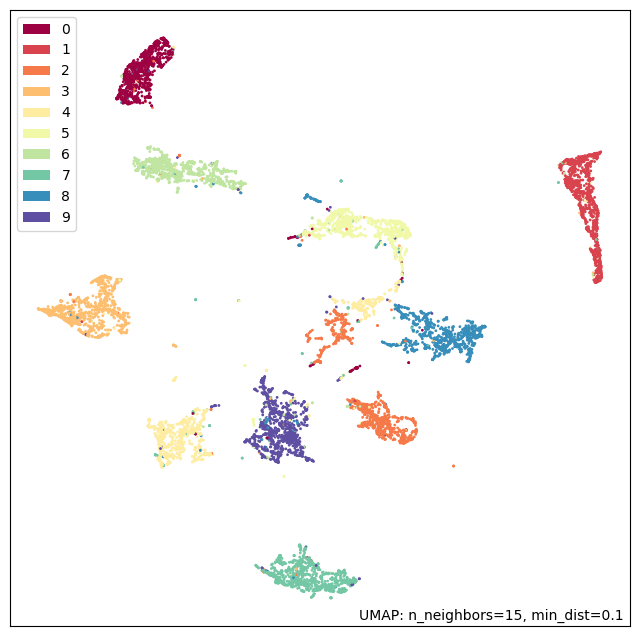

In [64]:
imgs = np.array(lyrpreds).reshape(sz,20)
labels = np.argmax(np.asarray(y_test_true).reshape(sz,20), axis=1)

mapper = umap.UMAP().fit(imgs, labels)
umap.plot.points(mapper, labels=labels)

In [65]:
imgs = np.asarray(x_test_true).reshape(sz, 784).astype("float32") / 255
labels = np.argmax(np.array(preds).reshape(sz,20), axis=1)
mapper = umap.UMAP().fit(imgs)
umap.plot.points(mapper, labels=labels)

<Axes: >

<Axes: >

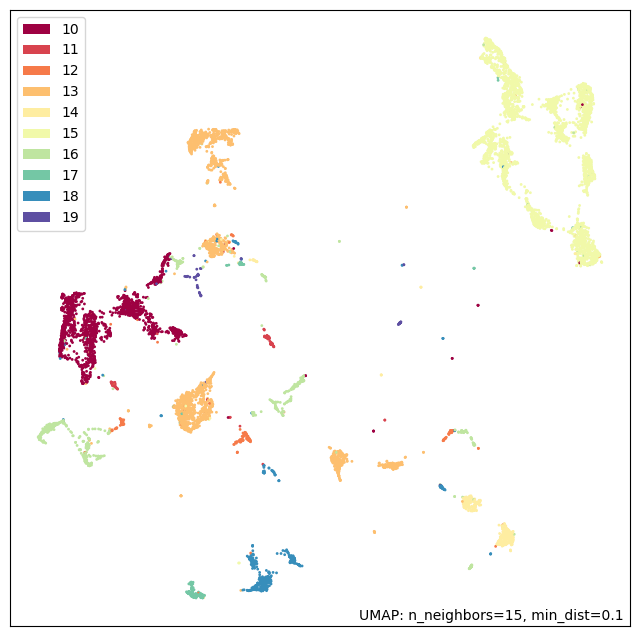

In [66]:
imgs = np.asarray(x_test_true).reshape(sz, 784).astype("float32") / 255
labels = np.argmax(np.array(preds).reshape(sz,20), axis=1)
mapper = umap.UMAP().fit(imgs, labels)
umap.plot.points(mapper, labels=labels)

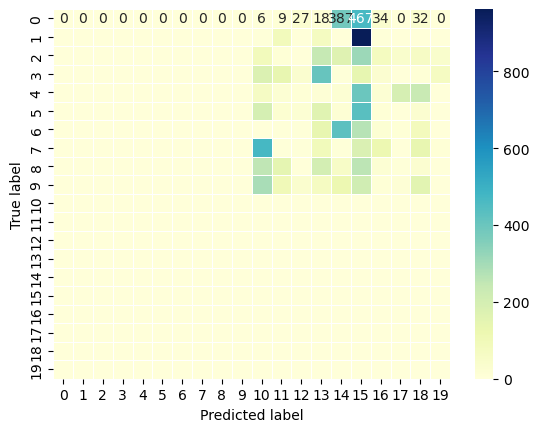

In [67]:
#Previous Task A  Perfomrance Evals

dataset = test_dataset
preds = []
weight_preds = []
lyrpreds = []
y_test_true = []
x_test_true = []

for tstep, (xt, yt) in enumerate(dataset):
    x_test_true.append(xt)
    y_test_true.append(yt)
    _, _, pred, lyr, weight_pred = test_step(xt, yt, WGN_NoP_B)
    preds.append(pred)
    weight_preds.append(weight_pred)
    lyrpreds.append(lyr)
tstacc_fn.reset_states()

y_test_arg = np.argmax(y_test_true, axis=-1)
y_pred = np.argmax(preds, axis=-1)
A_No_P = accuracy_score(y_test_arg, y_pred )

#confusionmat
y_test_arg = np.argmax(y_test_true, axis=-1)
y_pred = np.argmax(preds, axis=-1)
cm = confusion_matrix(y_test_arg, y_pred)

plt.figure()
sns.heatmap(cm, fmt = 'd' , cmap="YlGnBu",  annot=True, linewidths=.5)

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [68]:
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

avg = None

acs = accuracy_score(y_test_arg, y_pred)
pcs = precision_score(y_test_arg, y_pred, average = avg)
rcs = recall_score(y_test_arg, y_pred, average = avg)
fcs = f1_score(y_test_arg, y_pred, average = avg)

prfs = precision_recall_fscore_support(y_test_arg, y_pred, average = avg)

print("\nAverging = ", avg, "\naccuracy = ", acs, "\nprecision = ", pcs, "\nrecall = ", rcs, "\nf1 score = ", fcs)
print("\nclasswise metrics = ", prfs)

avg = "micro"

acs = accuracy_score(y_test_arg, y_pred)
pcs = precision_score(y_test_arg, y_pred, average = avg)
rcs = recall_score(y_test_arg, y_pred, average = avg)
fcs = f1_score(y_test_arg, y_pred, average = avg)

prfs = precision_recall_fscore_support(y_test_arg, y_pred, average = avg)

print("\nAverging = ", avg, "\n\naccuracy = ", acs, "\nprecision = ", pcs, "\nrecall = ", rcs, "\nf1 score = ", fcs)
print("\nclasswise metrics = ", prfs)

avg = "macro"

acs = accuracy_score(y_test_arg, y_pred)
pcs = precision_score(y_test_arg, y_pred, average = avg)
rcs = recall_score(y_test_arg, y_pred, average = avg)
fcs = f1_score(y_test_arg, y_pred, average = avg)

prfs = precision_recall_fscore_support(y_test_arg, y_pred, average = avg)

print("\nAverging = ", avg, "\naccuracy = ", acs, "\nprecision = ", pcs, "\nrecall = ", rcs, "\nf1 score = ", fcs)
print("\nclasswise metrics = ", prfs)

avg = "weighted"

acs = accuracy_score(y_test_arg, y_pred)
pcs = precision_score(y_test_arg, y_pred, average = avg)
rcs = recall_score(y_test_arg, y_pred, average = avg)
fcs = f1_score(y_test_arg, y_pred, average = avg)

prfs = precision_recall_fscore_support(y_test_arg, y_pred, average = avg)

print("\nAverging = ", avg, "\naccuracy = ", acs, "\nprecision = ", pcs, "\nrecall = ", rcs, "\nf1 score = ", fcs)
print("\nclasswise metrics = ", prfs)


Averging =  None 
accuracy =  0.0 
precision =  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] 
recall =  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] 
f1 score =  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]

classwise metrics =  (array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0.]), array([ 980., 1135., 1032., 1010.,  982.,  892.,  958., 1028.,  974.,
       1009.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.]))

Averging =  micro 

accuracy =  0.0 
precision =  0.0 
recall =  0.0 
f1 score =  0.0

classwise metrics =  (0.0, 0.0, 0.0, None)

Averging =  macro 
accuracy =  0.0 
precision =  0.0 
recall =  0.0 
f1 score =  0.0

classwise metrics =  (0.0, 0.0, 0.0, None)

Averg

/home/shriraj/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/shriraj/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/shriraj/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/shriraj/anacond

In [ ]:
import umap
import umap.plot

sz=10000

imgs = np.array(weight_preds).reshape(sz,num_weights_to_generate)
labels = np.argmax(np.array(preds).reshape(sz,20), axis=1)

mapper = umap.UMAP().fit(imgs)
umap.plot.points(mapper, labels=labels)

In [ ]:
imgs = np.array(weight_preds).reshape(sz,num_weights_to_generate)
labels = np.argmax(np.array(preds).reshape(sz,20), axis=1)

mapper = umap.UMAP().fit(imgs, labels)
umap.plot.points(mapper, labels=labels)

In [ ]:
imgs = np.array(weight_preds).reshape(sz,num_weights_to_generate)
labels = np.argmax(np.asarray(y_test_true).reshape(sz,20), axis=1)

mapper = umap.UMAP().fit(imgs)
umap.plot.points(mapper, labels=labels)

In [ ]:
imgs = np.array(weight_preds).reshape(sz,num_weights_to_generate)
labels = np.argmax(np.asarray(y_test_true).reshape(sz,20), axis=1)

mapper = umap.UMAP().fit(imgs, labels)
umap.plot.points(mapper, labels=labels)

In [ ]:
imgs = np.array(lyrpreds).reshape(sz,20)
labels = np.argmax(np.array(preds).reshape(sz,20), axis=1)

mapper = umap.UMAP().fit(imgs)
umap.plot.points(mapper, labels=labels)

In [ ]:
imgs = np.array(lyrpreds).reshape(sz,20)
labels = np.argmax(np.array(preds).reshape(sz,20), axis=1)

mapper = umap.UMAP().fit(imgs, labels)
umap.plot.points(mapper, labels=labels)

In [ ]:
imgs = np.array(lyrpreds).reshape(sz,20)
labels = np.argmax(np.asarray(y_test_true).reshape(sz,20), axis=1)

mapper = umap.UMAP().fit(imgs)
umap.plot.points(mapper, labels=labels)

In [ ]:
imgs = np.array(lyrpreds).reshape(sz,20)
labels = np.argmax(np.asarray(y_test_true).reshape(sz,20), axis=1)

mapper = umap.UMAP().fit(imgs, labels)
umap.plot.points(mapper, labels=labels)

In [ ]:
imgs = np.asarray(x_test_true).reshape(sz, 784).astype("float32") / 255
labels = np.argmax(np.array(preds).reshape(sz,20), axis=1)
mapper = umap.UMAP().fit(imgs)
umap.plot.points(mapper, labels=labels)

In [ ]:
imgs = np.asarray(x_test_true).reshape(sz, 784).astype("float32") / 255
labels = np.argmax(np.array(preds).reshape(sz,20), axis=1)
mapper = umap.UMAP().fit(imgs, labels)
umap.plot.points(mapper, labels=labels)

In [69]:
#Task A OG Perfomrance Evals
dataset = test_dataset
preds = []
weight_preds = []
lyrpreds = []
y_test_true = []
x_test_true = []

for tstep, (xt, yt) in enumerate(dataset):
    x_test_true.append(xt)
    y_test_true.append(yt)
    _, _, pred, lyr, weight_pred = test_step(xt, yt, WGN)
    preds.append(pred)
    weight_preds.append(weight_pred)
    lyrpreds.append(lyr)
tstacc_fn.reset_states()

y_test_arg = np.argmax(y_test_true, axis=-1)
y_pred = np.argmax(preds, axis=-1)
A_OG = accuracy_score(y_test_arg, y_pred )

#confusionmat
y_test_arg = np.argmax(y_test_true, axis=-1)
y_pred = np.argmax(preds, axis=-1)
cm = confusion_matrix(y_test_arg, y_pred)

plt.figure()
sns.heatmap(cm, fmt = 'd' , cmap="YlGnBu",  annot=True, linewidths=.5)

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [70]:
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

avg = None

acs = accuracy_score(y_test_arg, y_pred)
pcs = precision_score(y_test_arg, y_pred, average = avg)
rcs = recall_score(y_test_arg, y_pred, average = avg)
fcs = f1_score(y_test_arg, y_pred, average = avg)

prfs = precision_recall_fscore_support(y_test_arg, y_pred, average = avg)

print("\nAverging = ", avg, "\naccuracy = ", acs, "\nprecision = ", pcs, "\nrecall = ", rcs, "\nf1 score = ", fcs)
print("\nclasswise metrics = ", prfs)

avg = "micro"

acs = accuracy_score(y_test_arg, y_pred)
pcs = precision_score(y_test_arg, y_pred, average = avg)
rcs = recall_score(y_test_arg, y_pred, average = avg)
fcs = f1_score(y_test_arg, y_pred, average = avg)

prfs = precision_recall_fscore_support(y_test_arg, y_pred, average = avg)

print("\nAverging = ", avg, "\n\naccuracy = ", acs, "\nprecision = ", pcs, "\nrecall = ", rcs, "\nf1 score = ", fcs)
print("\nclasswise metrics = ", prfs)

avg = "macro"

acs = accuracy_score(y_test_arg, y_pred)
pcs = precision_score(y_test_arg, y_pred, average = avg)
rcs = recall_score(y_test_arg, y_pred, average = avg)
fcs = f1_score(y_test_arg, y_pred, average = avg)

prfs = precision_recall_fscore_support(y_test_arg, y_pred, average = avg)

print("\nAverging = ", avg, "\naccuracy = ", acs, "\nprecision = ", pcs, "\nrecall = ", rcs, "\nf1 score = ", fcs)
print("\nclasswise metrics = ", prfs)

avg = "weighted"

acs = accuracy_score(y_test_arg, y_pred)
pcs = precision_score(y_test_arg, y_pred, average = avg)
rcs = recall_score(y_test_arg, y_pred, average = avg)
fcs = f1_score(y_test_arg, y_pred, average = avg)

prfs = precision_recall_fscore_support(y_test_arg, y_pred, average = avg)

print("\nAverging = ", avg, "\naccuracy = ", acs, "\nprecision = ", pcs, "\nrecall = ", rcs, "\nf1 score = ", fcs)
print("\nclasswise metrics = ", prfs)


Averging =  None 
accuracy =  0.9733 
precision =  [0.97865854 0.98510079 0.9673391  0.98773006 0.96787149 0.96013289
 0.97190427 0.97270955 0.96694215 0.97205589] 
recall =  [0.98265306 0.99030837 0.97577519 0.95643564 0.98167006 0.97197309
 0.97494781 0.97081712 0.96098563 0.96531219] 
f1 score =  [0.98065173 0.98769772 0.97153883 0.97183099 0.97472194 0.96601671
 0.97342366 0.97176241 0.96395469 0.9686723 ]

classwise metrics =  (array([0.97865854, 0.98510079, 0.9673391 , 0.98773006, 0.96787149,
       0.96013289, 0.97190427, 0.97270955, 0.96694215, 0.97205589]), array([0.98265306, 0.99030837, 0.97577519, 0.95643564, 0.98167006,
       0.97197309, 0.97494781, 0.97081712, 0.96098563, 0.96531219]), array([0.98065173, 0.98769772, 0.97153883, 0.97183099, 0.97472194,
       0.96601671, 0.97342366, 0.97176241, 0.96395469, 0.9686723 ]), array([ 980, 1135, 1032, 1010,  982,  892,  958, 1028,  974, 1009]))

Averging =  micro 

accuracy =  0.9733 
precision =  0.9733 
recall =  0.9733 
f1 sc

In [ ]:
import umap
import umap.plot

sz=10000

imgs = np.array(weight_preds).reshape(sz,num_weights_to_generate)
labels = np.argmax(np.array(preds).reshape(sz,20), axis=1)

mapper = umap.UMAP().fit(imgs)
umap.plot.points(mapper, labels=labels)

In [ ]:
imgs = np.array(weight_preds).reshape(sz,num_weights_to_generate)
labels = np.argmax(np.array(preds).reshape(sz,20), axis=1)

mapper = umap.UMAP().fit(imgs, labels)
umap.plot.points(mapper, labels=labels)

In [ ]:
imgs = np.array(weight_preds).reshape(sz,num_weights_to_generate)
labels = np.argmax(np.asarray(y_test_true).reshape(sz,20), axis=1)

mapper = umap.UMAP().fit(imgs)
umap.plot.points(mapper, labels=labels)

In [ ]:
imgs = np.array(weight_preds).reshape(sz,num_weights_to_generate)
labels = np.argmax(np.asarray(y_test_true).reshape(sz,20), axis=1)

mapper = umap.UMAP().fit(imgs, labels)
umap.plot.points(mapper, labels=labels)

In [ ]:
imgs = np.array(lyrpreds).reshape(sz,20)
labels = np.argmax(np.array(preds).reshape(sz,20), axis=1)

mapper = umap.UMAP().fit(imgs)
umap.plot.points(mapper, labels=labels)

In [ ]:
imgs = np.array(lyrpreds).reshape(sz,20)
labels = np.argmax(np.array(preds).reshape(sz,20), axis=1)

mapper = umap.UMAP().fit(imgs, labels)
umap.plot.points(mapper, labels=labels)

In [ ]:
imgs = np.array(lyrpreds).reshape(sz,20)
labels = np.argmax(np.asarray(y_test_true).reshape(sz,20), axis=1)

mapper = umap.UMAP().fit(imgs)
umap.plot.points(mapper, labels=labels)

In [ ]:
imgs = np.array(lyrpreds).reshape(sz,20)
labels = np.argmax(np.asarray(y_test_true).reshape(sz,20), axis=1)

mapper = umap.UMAP().fit(imgs, labels)
umap.plot.points(mapper, labels=labels)

In [ ]:
imgs = np.asarray(x_test_true).reshape(sz, 784).astype("float32") / 255
labels = np.argmax(np.array(preds).reshape(sz,20), axis=1)
mapper = umap.UMAP().fit(imgs)
umap.plot.points(mapper, labels=labels)

In [ ]:
imgs = np.asarray(x_test_true).reshape(sz, 784).astype("float32") / 255
labels = np.argmax(np.array(preds).reshape(sz,20), axis=1)
mapper = umap.UMAP().fit(imgs, labels)
umap.plot.points(mapper, labels=labels)

In [75]:
print("Task A Original Accuracy: %.2f%%" % (100*A_OG))
print("Task B EWC method penalty Accuracy: %.2f%%" % (100*B_EWC))
print("Task B SGD method Accuracy: %.2f%%" % (100*B_No_P))
print("Task A EWC method penalty Accuracy: %.2f%%" % (100*A_EWC))
print("Task A SGD method Accuracy: %.2f%%" % (100*A_No_P))



Task A Original Accuracy: 97.33%
Task B EWC method penalty Accuracy: 86.94%
Task B SGD method Accuracy: 86.86%
Task A EWC method penalty Accuracy: 0.00%
Task A SGD method Accuracy: 0.00%


In [76]:
import pandas as pd
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix

#Current Task B Perfomrance Evals
dataset = abtest_dataset
preds = []
weight_preds = []
lyrpreds = []
y_test_true = []
x_test_true = []

for tstep, (xt, yt) in enumerate(dataset):
    x_test_true.append(xt)
    y_test_true.append(yt)
    _, _, pred, lyr, weight_pred = test_step(xt, yt, WGN_ewcB)
    preds.append(pred)
    weight_preds.append(weight_pred)
    lyrpreds.append(lyr)
tstacc_fn.reset_states()

y_test_arg = np.argmax(y_test_true, axis=-1)
y_pred = np.argmax(preds, axis=-1)
B_EWC = accuracy_score(y_test_arg, y_pred )

#confusionmat
cm = confusion_matrix(y_test_arg, y_pred)

plt.figure()
sns.heatmap(cm, fmt = 'd' , cmap="YlGnBu",  annot=True, linewidths=.5)

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()



In [77]:
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

avg = None

acs = accuracy_score(y_test_arg, y_pred)
pcs = precision_score(y_test_arg, y_pred, average = avg)
rcs = recall_score(y_test_arg, y_pred, average = avg)
fcs = f1_score(y_test_arg, y_pred, average = avg)

prfs = precision_recall_fscore_support(y_test_arg, y_pred, average = avg)

print("\nAverging = ", avg, "\naccuracy = ", acs, "\nprecision = ", pcs, "\nrecall = ", rcs, "\nf1 score = ", fcs)
print("\nclasswise metrics = ", prfs)

avg = "micro"

acs = accuracy_score(y_test_arg, y_pred)
pcs = precision_score(y_test_arg, y_pred, average = avg)
rcs = recall_score(y_test_arg, y_pred, average = avg)
fcs = f1_score(y_test_arg, y_pred, average = avg)

prfs = precision_recall_fscore_support(y_test_arg, y_pred, average = avg)

print("\nAverging = ", avg, "\n\naccuracy = ", acs, "\nprecision = ", pcs, "\nrecall = ", rcs, "\nf1 score = ", fcs)
print("\nclasswise metrics = ", prfs)

avg = "macro"

acs = accuracy_score(y_test_arg, y_pred)
pcs = precision_score(y_test_arg, y_pred, average = avg)
rcs = recall_score(y_test_arg, y_pred, average = avg)
fcs = f1_score(y_test_arg, y_pred, average = avg)

prfs = precision_recall_fscore_support(y_test_arg, y_pred, average = avg)

print("\nAverging = ", avg, "\naccuracy = ", acs, "\nprecision = ", pcs, "\nrecall = ", rcs, "\nf1 score = ", fcs)
print("\nclasswise metrics = ", prfs)

avg = "weighted"

acs = accuracy_score(y_test_arg, y_pred)
pcs = precision_score(y_test_arg, y_pred, average = avg)
rcs = recall_score(y_test_arg, y_pred, average = avg)
fcs = f1_score(y_test_arg, y_pred, average = avg)

prfs = precision_recall_fscore_support(y_test_arg, y_pred, average = avg)

print("\nAverging = ", avg, "\naccuracy = ", acs, "\nprecision = ", pcs, "\nrecall = ", rcs, "\nf1 score = ", fcs)
print("\nclasswise metrics = ", prfs)


Averging =  None 
accuracy =  0.4347 
precision =  [0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.27783632 0.85537919
 0.64154104 0.27045124 0.51044386 0.22021082 0.3866746  0.76309428
 0.62827225 0.89846743] 
recall =  [0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.791 0.97
 0.766 0.929 0.782 0.961 0.65  0.947 0.96  0.938] 
f1 score =  [0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.41122953 0.90909091
 0.698268   0.41894025 0.61769352 0.35831469 0.4848937  0.84515841
 0.75949367 0.91780822]

classwise metrics =  (array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.27783632, 0.85537919, 0.64154104, 0.27045124, 0.51044386,
       0.22021082, 0.3866746 , 0.76309428, 0.62827225, 0.89846743]), array([0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
     

/home/shriraj/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/shriraj/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/shriraj/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/shriraj

<Axes: >

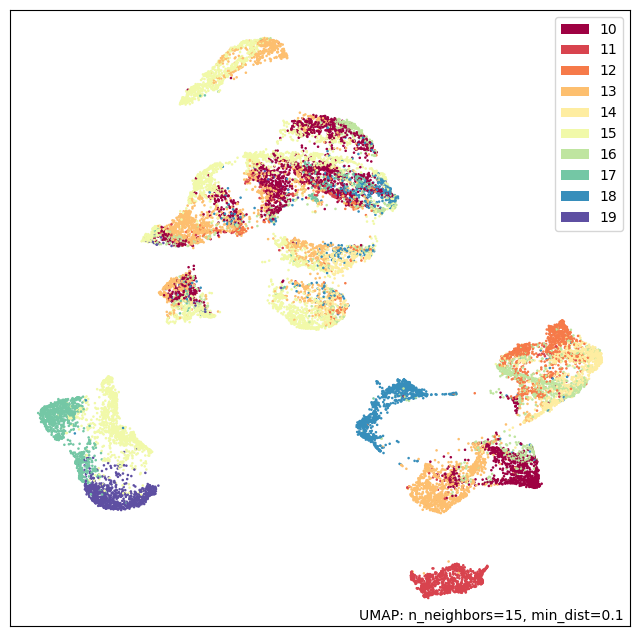

In [78]:
import umap
import umap.plot

sz=20000

imgs = np.array(weight_preds).reshape(sz,num_weights_to_generate)
labels = np.argmax(np.array(preds).reshape(sz,20), axis=1)

mapper = umap.UMAP().fit(imgs)
umap.plot.points(mapper, labels=labels)

<Axes: >

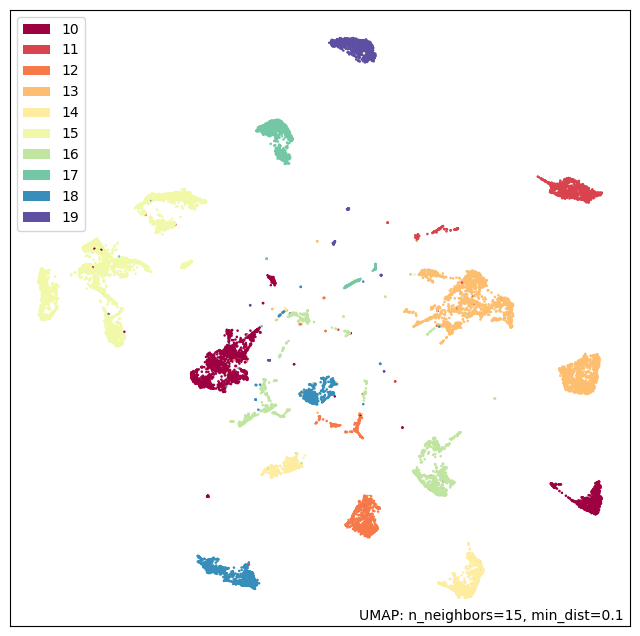

In [79]:
imgs = np.array(weight_preds).reshape(sz,num_weights_to_generate)
labels = np.argmax(np.array(preds).reshape(sz,20), axis=1)

mapper = umap.UMAP().fit(imgs, labels)
umap.plot.points(mapper, labels=labels)

<Axes: >

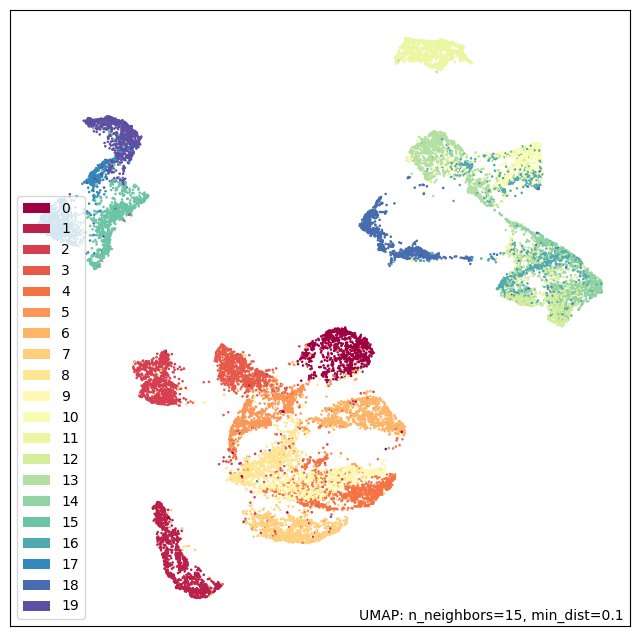

In [80]:
imgs = np.array(weight_preds).reshape(sz,num_weights_to_generate)
labels = np.argmax(np.asarray(y_test_true).reshape(sz,20), axis=1)

mapper = umap.UMAP().fit(imgs)
umap.plot.points(mapper, labels=labels)

<Axes: >

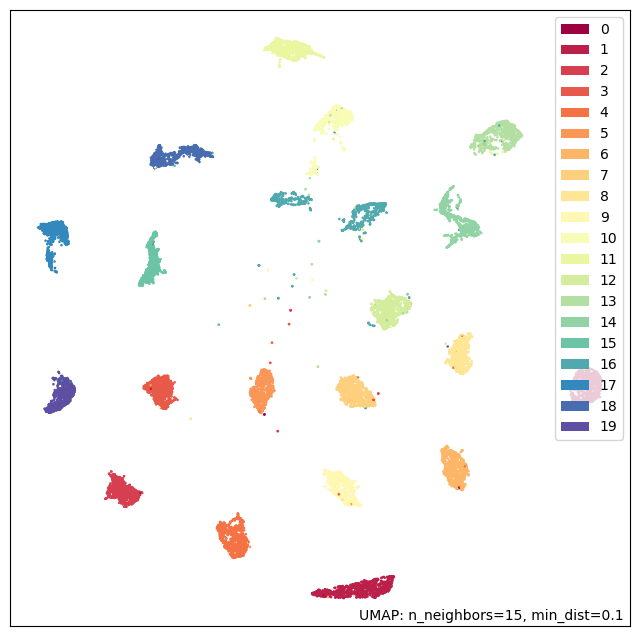

In [81]:
imgs = np.array(weight_preds).reshape(sz,num_weights_to_generate)
labels = np.argmax(np.asarray(y_test_true).reshape(sz,20), axis=1)

mapper = umap.UMAP().fit(imgs, labels)
umap.plot.points(mapper, labels=labels)

In [82]:
imgs = np.array(lyrpreds).reshape(sz,20)
labels = np.argmax(np.array(preds).reshape(sz,20), axis=1)

mapper = umap.UMAP().fit(imgs)
umap.plot.points(mapper, labels=labels)

<Axes: >

In [83]:
imgs = np.array(lyrpreds).reshape(sz,20)
labels = np.argmax(np.array(preds).reshape(sz,20), axis=1)

mapper = umap.UMAP().fit(imgs, labels)
umap.plot.points(mapper, labels=labels)

<Axes: >

<Axes: >

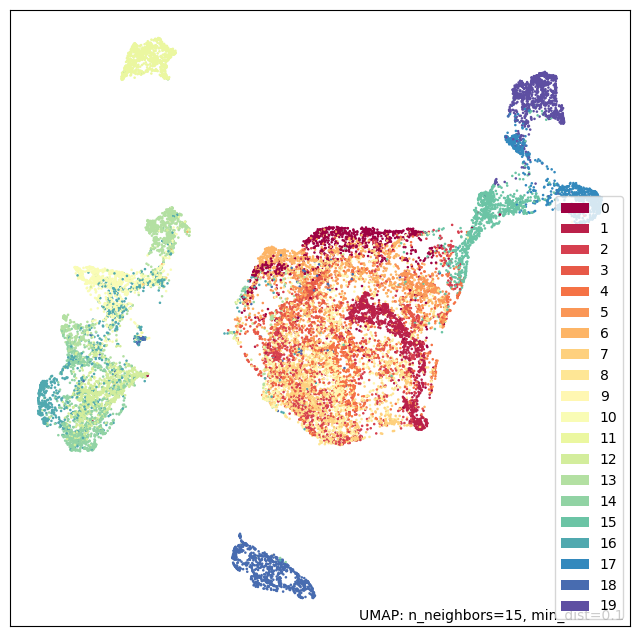

In [84]:
imgs = np.array(lyrpreds).reshape(sz,20)
labels = np.argmax(np.asarray(y_test_true).reshape(sz,20), axis=1)

mapper = umap.UMAP().fit(imgs)
umap.plot.points(mapper, labels=labels)

In [85]:
imgs = np.array(lyrpreds).reshape(sz,20)
labels = np.argmax(np.asarray(y_test_true).reshape(sz,20), axis=1)

mapper = umap.UMAP().fit(imgs, labels)
umap.plot.points(mapper, labels=labels)

<Axes: >

In [86]:
imgs = np.asarray(x_test_true).reshape(sz, 784).astype("float32") / 255
labels = np.argmax(np.array(preds).reshape(sz,20), axis=1)
mapper = umap.UMAP().fit(imgs)
umap.plot.points(mapper, labels=labels)

<Axes: >

<Axes: >

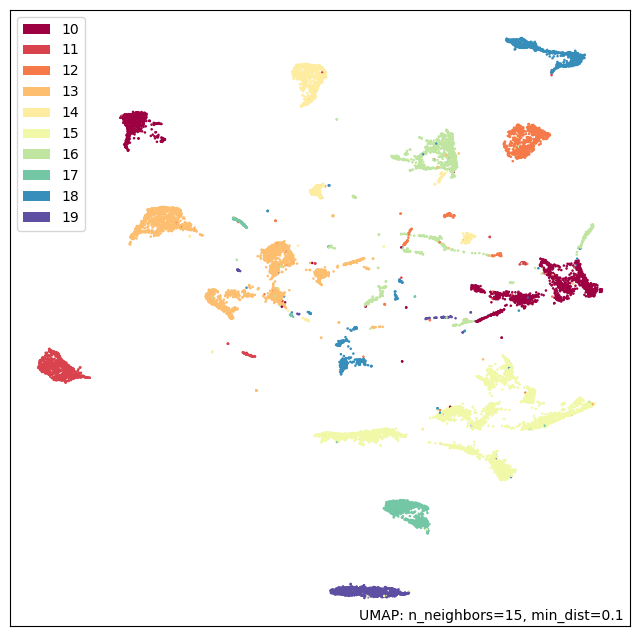

In [87]:
imgs = np.asarray(x_test_true).reshape(sz, 784).astype("float32") / 255
labels = np.argmax(np.array(preds).reshape(sz,20), axis=1)
mapper = umap.UMAP().fit(imgs, labels)
umap.plot.points(mapper, labels=labels)

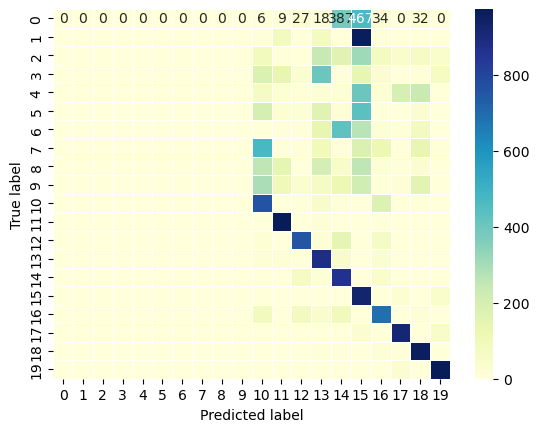

In [88]:
#Current Task B Perfomrance Evals

dataset = abtest_dataset
preds = []
weight_preds = []
lyrpreds = []
y_test_true = []
x_test_true = []

for tstep, (xt, yt) in enumerate(dataset):
    x_test_true.append(xt)
    y_test_true.append(yt)
    _, _, pred, lyr, weight_pred = test_step(xt, yt, WGN_NoP_B)
    preds.append(pred)
    weight_preds.append(weight_pred)
    lyrpreds.append(lyr)
tstacc_fn.reset_states()

y_test_arg = np.argmax(y_test_true, axis=-1)
y_pred = np.argmax(preds, axis=-1)
B_No_P = accuracy_score(y_test_arg, y_pred )

#confusionmat
cm = confusion_matrix(y_test_arg, y_pred)

plt.figure()
sns.heatmap(cm, fmt = 'd' , cmap="YlGnBu",  annot=True, linewidths=.5)

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [89]:
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

avg = None

acs = accuracy_score(y_test_arg, y_pred)
pcs = precision_score(y_test_arg, y_pred, average = avg)
rcs = recall_score(y_test_arg, y_pred, average = avg)
fcs = f1_score(y_test_arg, y_pred, average = avg)

prfs = precision_recall_fscore_support(y_test_arg, y_pred, average = avg)

print("\nAverging = ", avg, "\naccuracy = ", acs, "\nprecision = ", pcs, "\nrecall = ", rcs, "\nf1 score = ", fcs)
print("\nclasswise metrics = ", prfs)

avg = "micro"

acs = accuracy_score(y_test_arg, y_pred)
pcs = precision_score(y_test_arg, y_pred, average = avg)
rcs = recall_score(y_test_arg, y_pred, average = avg)
fcs = f1_score(y_test_arg, y_pred, average = avg)

prfs = precision_recall_fscore_support(y_test_arg, y_pred, average = avg)

print("\nAverging = ", avg, "\n\naccuracy = ", acs, "\nprecision = ", pcs, "\nrecall = ", rcs, "\nf1 score = ", fcs)
print("\nclasswise metrics = ", prfs)

avg = "macro"

acs = accuracy_score(y_test_arg, y_pred)
pcs = precision_score(y_test_arg, y_pred, average = avg)
rcs = recall_score(y_test_arg, y_pred, average = avg)
fcs = f1_score(y_test_arg, y_pred, average = avg)

prfs = precision_recall_fscore_support(y_test_arg, y_pred, average = avg)

print("\nAverging = ", avg, "\naccuracy = ", acs, "\nprecision = ", pcs, "\nrecall = ", rcs, "\nf1 score = ", fcs)
print("\nclasswise metrics = ", prfs)

avg = "weighted"

acs = accuracy_score(y_test_arg, y_pred)
pcs = precision_score(y_test_arg, y_pred, average = avg)
rcs = recall_score(y_test_arg, y_pred, average = avg)
fcs = f1_score(y_test_arg, y_pred, average = avg)

prfs = precision_recall_fscore_support(y_test_arg, y_pred, average = avg)

print("\nAverging = ", avg, "\naccuracy = ", acs, "\nprecision = ", pcs, "\nrecall = ", rcs, "\nf1 score = ", fcs)
print("\nclasswise metrics = ", prfs)


Averging =  None 
accuracy =  0.4343 
precision =  [0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.3102459  0.63075925
 0.71631879 0.35851368 0.36402027 0.20186672 0.50478998 0.7409201
 0.5451448  0.81841216] 
recall =  [0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.757 0.972
 0.755 0.878 0.862 0.93  0.685 0.918 0.96  0.969] 
f1 score =  [0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.44011628 0.76505313
 0.73515093 0.50913308 0.51187648 0.3317282  0.58124735 0.82000893
 0.69540022 0.88736264]

classwise metrics =  (array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.3102459 , 0.63075925, 0.71631879, 0.35851368, 0.36402027,
       0.20186672, 0.50478998, 0.7409201 , 0.5451448 , 0.81841216]), array([0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
     

/home/shriraj/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/shriraj/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/shriraj/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/shriraj

In [103]:
import umap
import umap.plot

sz=20000

imgs = np.array(weight_preds).reshape(sz,num_weights_to_generate)
labels = np.argmax(np.array(preds).reshape(sz,20), axis=1)

mapper = umap.UMAP().fit(imgs)
umap.plot.points(mapper, labels=labels)

<Axes: >

In [104]:
imgs = np.array(weight_preds).reshape(sz,num_weights_to_generate)
labels = np.argmax(np.array(preds).reshape(sz,20), axis=1)

mapper = umap.UMAP().fit(imgs, labels)
umap.plot.points(mapper, labels=labels)

<Axes: >

<Axes: >

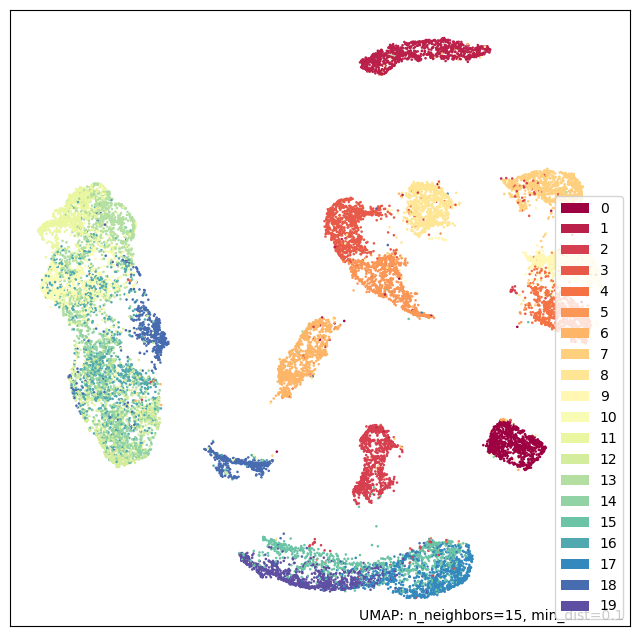

In [105]:
imgs = np.array(weight_preds).reshape(sz,num_weights_to_generate)
labels = np.argmax(np.asarray(y_test_true).reshape(sz,20), axis=1)

mapper = umap.UMAP().fit(imgs)
umap.plot.points(mapper, labels=labels)

<Axes: >

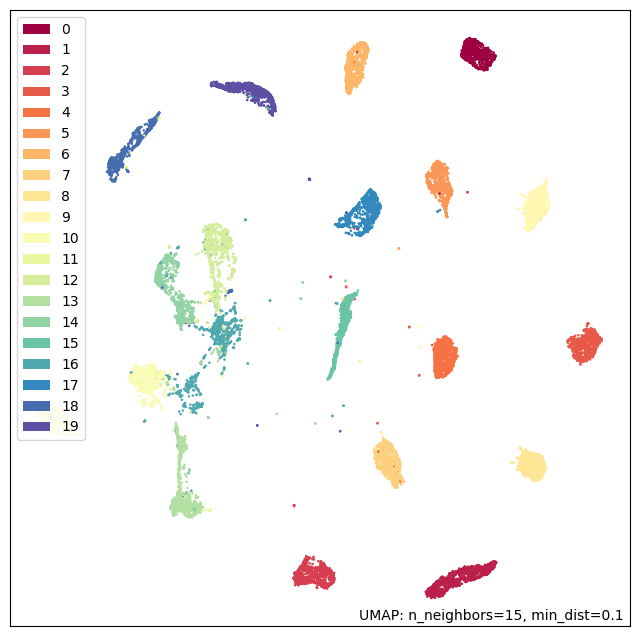

In [106]:
imgs = np.array(weight_preds).reshape(sz,num_weights_to_generate)
labels = np.argmax(np.asarray(y_test_true).reshape(sz,20), axis=1)

mapper = umap.UMAP().fit(imgs, labels)
umap.plot.points(mapper, labels=labels)

<Axes: >

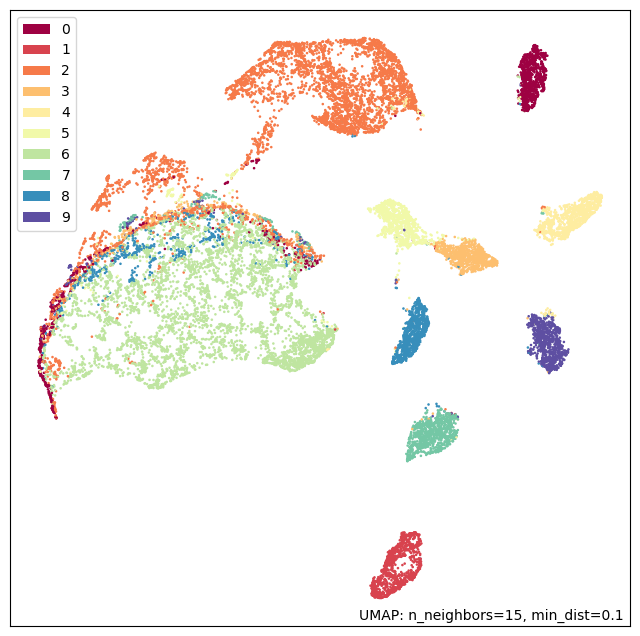

In [107]:
imgs = np.array(lyrpreds).reshape(sz,20)
labels = np.argmax(np.array(preds).reshape(sz,20), axis=1)

mapper = umap.UMAP().fit(imgs)
umap.plot.points(mapper, labels=labels)

<Axes: >

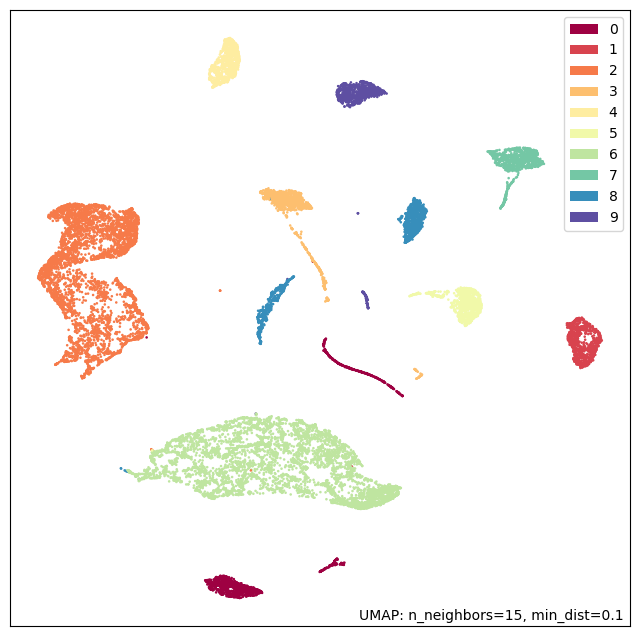

In [108]:
imgs = np.array(lyrpreds).reshape(sz,20)
labels = np.argmax(np.array(preds).reshape(sz,20), axis=1)

mapper = umap.UMAP().fit(imgs, labels)
umap.plot.points(mapper, labels=labels)

<Axes: >

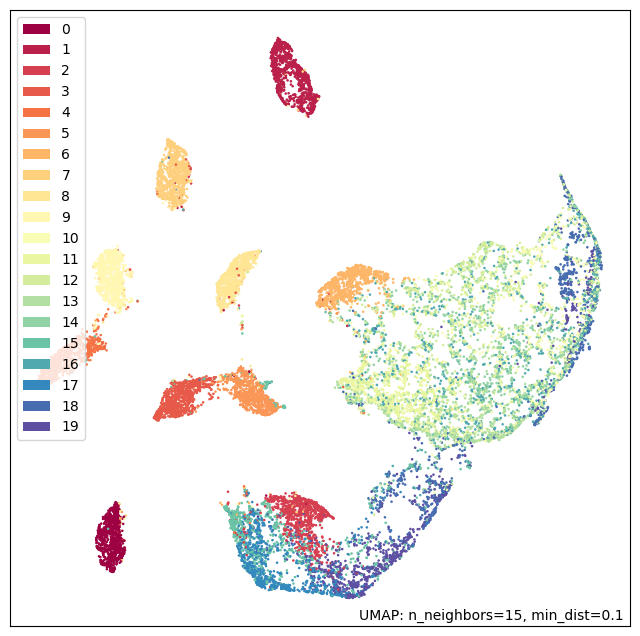

In [109]:
imgs = np.array(lyrpreds).reshape(sz,20)
labels = np.argmax(np.asarray(y_test_true).reshape(sz,20), axis=1)

mapper = umap.UMAP().fit(imgs)
umap.plot.points(mapper, labels=labels)

<Axes: >

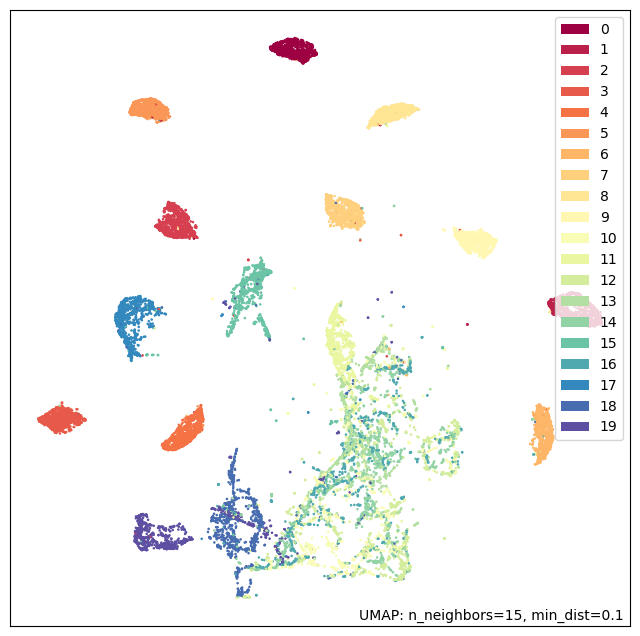

In [110]:
imgs = np.array(lyrpreds).reshape(sz,20)
labels = np.argmax(np.asarray(y_test_true).reshape(sz,20), axis=1)

mapper = umap.UMAP().fit(imgs, labels)
umap.plot.points(mapper, labels=labels)

<Axes: >

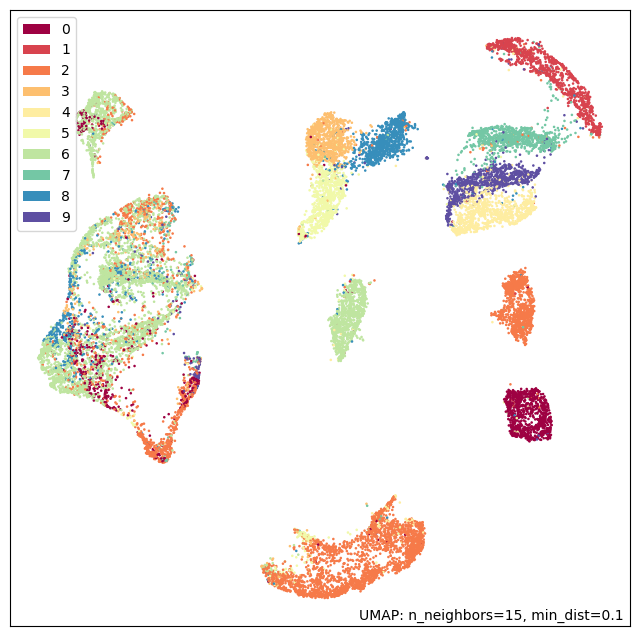

In [111]:
imgs = np.asarray(x_test_true).reshape(sz, 784).astype("float32") / 255
labels = np.argmax(np.array(preds).reshape(sz,20), axis=1)
mapper = umap.UMAP().fit(imgs)
umap.plot.points(mapper, labels=labels)

In [ ]:
imgs = np.asarray(x_test_true).reshape(sz, 784).astype("float32") / 255
labels = np.argmax(np.array(preds).reshape(sz,20), axis=1)
mapper = umap.UMAP().fit(imgs, labels)
umap.plot.points(mapper, labels=labels)

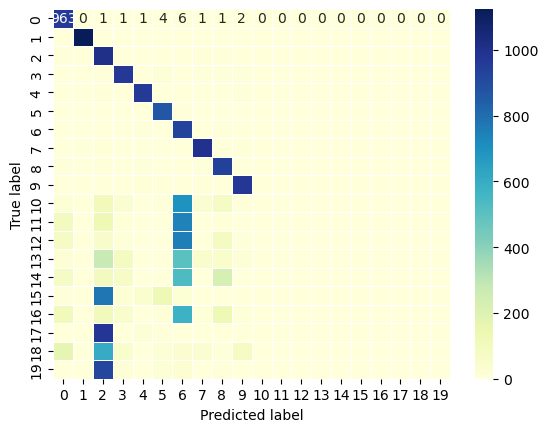

In [90]:
#Task A OG Perfomrance Evals
dataset = abtest_dataset
preds = []
weight_preds = []
lyrpreds = []
y_test_true = []
x_test_true = []
for tstep, (xt, yt) in enumerate(dataset):
    x_test_true.append(xt)
    y_test_true.append(yt)
    _, _, pred, lyr, weight_pred = test_step(xt, yt, WGN)
    preds.append(pred)
    weight_preds.append(weight_pred)
    lyrpreds.append(lyr)
tstacc_fn.reset_states()

y_test_arg = np.argmax(y_test_true, axis=-1)
y_pred = np.argmax(preds, axis=-1)
A_OG = accuracy_score(y_test_arg, y_pred )

#confusionmat
y_test_arg = np.argmax(y_test_true, axis=-1)
y_pred = np.argmax(preds, axis=-1)
cm = confusion_matrix(y_test_arg, y_pred)

plt.figure()
sns.heatmap(cm, fmt = 'd' , cmap="YlGnBu",  annot=True, linewidths=.5)

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [91]:
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

avg = None

acs = accuracy_score(y_test_arg, y_pred)
pcs = precision_score(y_test_arg, y_pred, average = avg)
rcs = recall_score(y_test_arg, y_pred, average = avg)
fcs = f1_score(y_test_arg, y_pred, average = avg)

prfs = precision_recall_fscore_support(y_test_arg, y_pred, average = avg)

print("\nAverging = ", avg, "\naccuracy = ", acs, "\nprecision = ", pcs, "\nrecall = ", rcs, "\nf1 score = ", fcs)
print("\nclasswise metrics = ", prfs)

avg = "micro"

acs = accuracy_score(y_test_arg, y_pred)
pcs = precision_score(y_test_arg, y_pred, average = avg)
rcs = recall_score(y_test_arg, y_pred, average = avg)
fcs = f1_score(y_test_arg, y_pred, average = avg)

prfs = precision_recall_fscore_support(y_test_arg, y_pred, average = avg)

print("\nAverging = ", avg, "\n\naccuracy = ", acs, "\nprecision = ", pcs, "\nrecall = ", rcs, "\nf1 score = ", fcs)
print("\nclasswise metrics = ", prfs)

avg = "macro"

acs = accuracy_score(y_test_arg, y_pred)
pcs = precision_score(y_test_arg, y_pred, average = avg)
rcs = recall_score(y_test_arg, y_pred, average = avg)
fcs = f1_score(y_test_arg, y_pred, average = avg)

prfs = precision_recall_fscore_support(y_test_arg, y_pred, average = avg)

print("\nAverging = ", avg, "\naccuracy = ", acs, "\nprecision = ", pcs, "\nrecall = ", rcs, "\nf1 score = ", fcs)
print("\nclasswise metrics = ", prfs)

avg = "weighted"

acs = accuracy_score(y_test_arg, y_pred)
pcs = precision_score(y_test_arg, y_pred, average = avg)
rcs = recall_score(y_test_arg, y_pred, average = avg)
fcs = f1_score(y_test_arg, y_pred, average = avg)

prfs = precision_recall_fscore_support(y_test_arg, y_pred, average = avg)

print("\nAverging = ", avg, "\naccuracy = ", acs, "\nprecision = ", pcs, "\nrecall = ", rcs, "\nf1 score = ", fcs)
print("\nclasswise metrics = ", prfs)


Averging =  None 
accuracy =  0.48665 
precision =  [0.61612284 0.98423818 0.19752844 0.73292868 0.91287879 0.78390597
 0.19241862 0.84863946 0.6        0.86424135 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ] 
recall =  [0.98265306 0.99030837 0.97577519 0.95643564 0.98167006 0.97197309
 0.97494781 0.97081712 0.96098563 0.96531219 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ] 
f1 score =  [0.75737318 0.98726394 0.32854812 0.82989691 0.94602552 0.86786787
 0.32140399 0.90562613 0.73875296 0.91198502 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]

classwise metrics =  (array([0.61612284, 0.98423818, 0.19752844, 0.73292868, 0.91287879,
       0.78390597, 0.19241862, 0.84863946, 0.6       , 0.86424135,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ]), arr

/home/shriraj/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/shriraj/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/shriraj/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/shriraj

<Axes: >

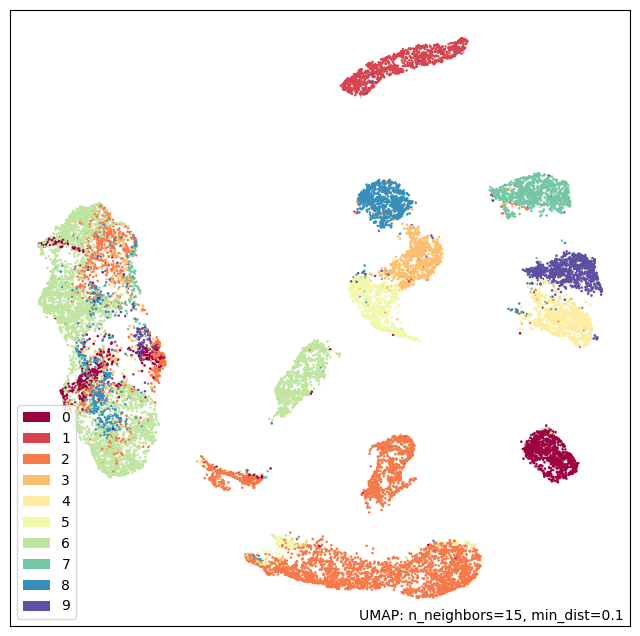

In [92]:
import umap
import umap.plot

sz=20000

imgs = np.array(weight_preds).reshape(sz,num_weights_to_generate)
labels = np.argmax(np.array(preds).reshape(sz,20), axis=1)

mapper = umap.UMAP().fit(imgs)
umap.plot.points(mapper, labels=labels)

<Axes: >

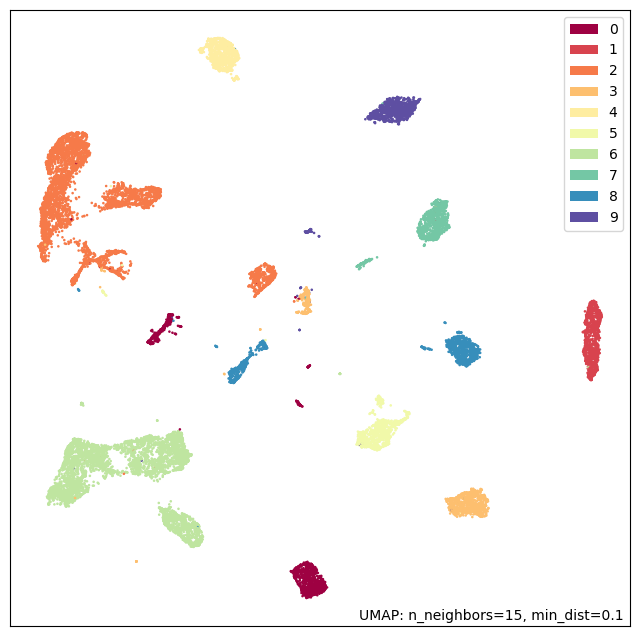

In [93]:
imgs = np.array(weight_preds).reshape(sz,num_weights_to_generate)
labels = np.argmax(np.array(preds).reshape(sz,20), axis=1)

mapper = umap.UMAP().fit(imgs, labels)
umap.plot.points(mapper, labels=labels)

<Axes: >

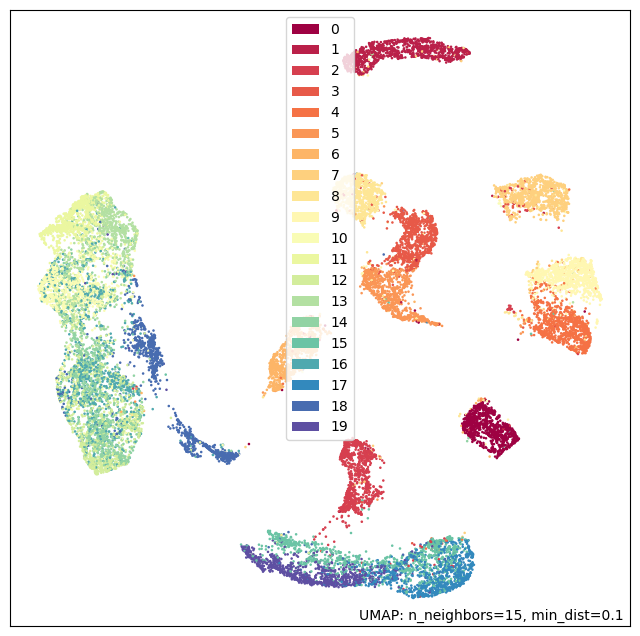

In [94]:
imgs = np.array(weight_preds).reshape(sz,num_weights_to_generate)
labels = np.argmax(np.asarray(y_test_true).reshape(sz,20), axis=1)

mapper = umap.UMAP().fit(imgs)
umap.plot.points(mapper, labels=labels)

<Axes: >

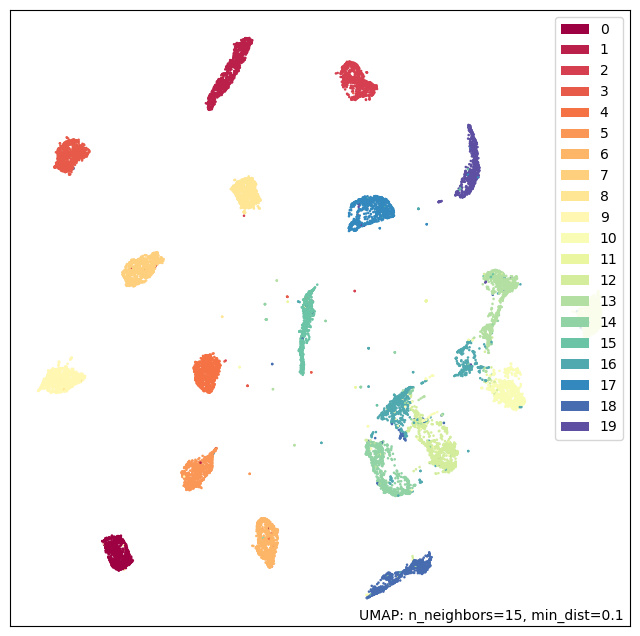

In [95]:
imgs = np.array(weight_preds).reshape(sz,num_weights_to_generate)
labels = np.argmax(np.asarray(y_test_true).reshape(sz,20), axis=1)

mapper = umap.UMAP().fit(imgs, labels)
umap.plot.points(mapper, labels=labels)

In [96]:
imgs = np.array(lyrpreds).reshape(sz,20)
labels = np.argmax(np.array(preds).reshape(sz,20), axis=1)

mapper = umap.UMAP().fit(imgs)
umap.plot.points(mapper, labels=labels)

<Axes: >

In [97]:
imgs = np.array(lyrpreds).reshape(sz,20)
labels = np.argmax(np.array(preds).reshape(sz,20), axis=1)

mapper = umap.UMAP().fit(imgs, labels)
umap.plot.points(mapper, labels=labels)

<Axes: >

<Axes: >

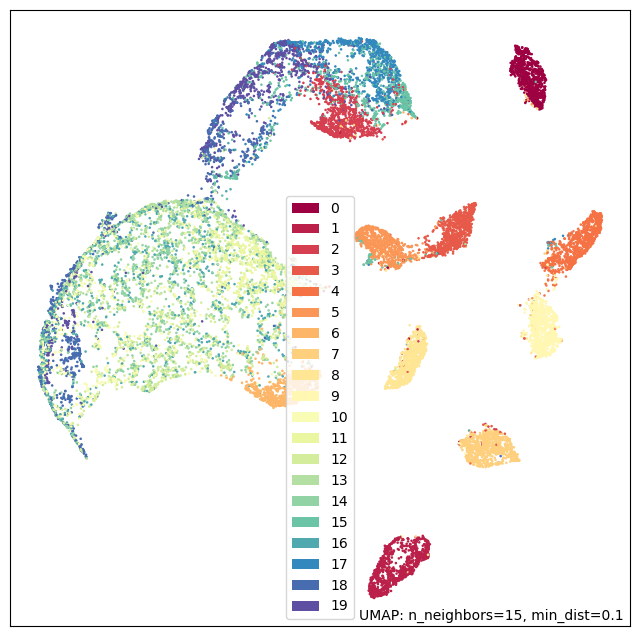

In [98]:
imgs = np.array(lyrpreds).reshape(sz,20)
labels = np.argmax(np.asarray(y_test_true).reshape(sz,20), axis=1)

mapper = umap.UMAP().fit(imgs)
umap.plot.points(mapper, labels=labels)

<Axes: >

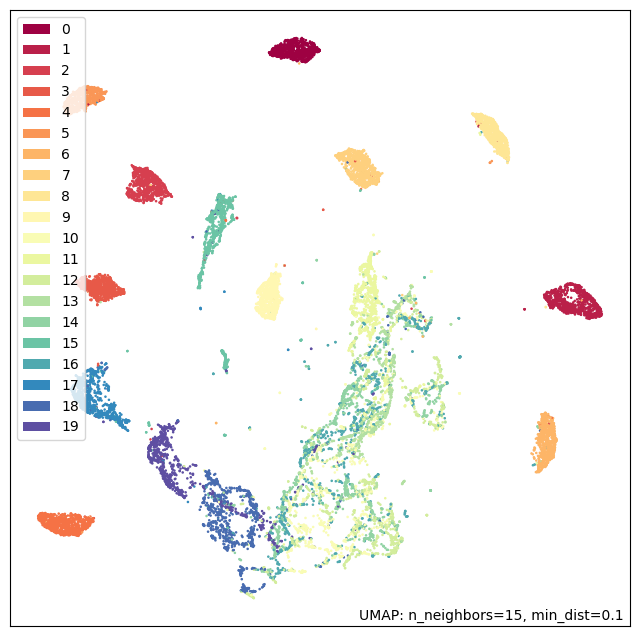

In [99]:
imgs = np.array(lyrpreds).reshape(sz,20)
labels = np.argmax(np.asarray(y_test_true).reshape(sz,20), axis=1)

mapper = umap.UMAP().fit(imgs, labels)
umap.plot.points(mapper, labels=labels)

In [100]:
imgs = np.asarray(x_test_true).reshape(sz, 784).astype("float32") / 255
labels = np.argmax(np.array(preds).reshape(sz,20), axis=1)
mapper = umap.UMAP().fit(imgs)
umap.plot.points(mapper, labels=labels)

<Axes: >

In [101]:
imgs = np.asarray(x_test_true).reshape(sz, 784).astype("float32") / 255
labels = np.argmax(np.array(preds).reshape(sz,20), axis=1)
mapper = umap.UMAP().fit(imgs, labels)
umap.plot.points(mapper, labels=labels)

<Axes: >

In [102]:
print("Task A Original Accuracy: %.2f%%" % (100*A_OG))
print("Task B EWC method penalty Accuracy: %.2f%%" % (100*B_EWC))
print("Task B SGD method Accuracy: %.2f%%" % (100*B_No_P))



Task A Original Accuracy: 48.67%
Task B EWC method penalty Accuracy: 43.47%
Task B SGD method Accuracy: 43.43%


# Fmnist first then Mnist

In [ ]:
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

In [ ]:
import numpy as np
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.regularizers import Regularizer

#tf.compat.v1.disable_eager_execution()

def computer_fisher(model, imgset, num_sample=30):
    f_accum = []
    for i in range(len(model.weights)):
        f_accum.append(np.zeros(K.int_shape(model.weights[i])))
    f_accum = np.array(f_accum)
    for j in range(num_sample):
        img_index = np.random.randint(imgset.shape[0])
        for m in range(len(model.weights)):                           
            grads = K.gradients(K.log(model.output), model.weights)[m]
            result = K.function([model.input], [grads])
            f_accum[m] += np.square(result([np.expand_dims(imgset[img_index], 0)])[0])
    f_accum /= num_sample
    return f_accum

def ecomputer_fisher(model, imgset, num_sample=30):
    f_accum = []
    for i in range(len(model.weights)):
        f_accum.append(tf.zeros(model.weights[i].shape))
    f_accum = np.array(f_accum)
    for x,y in imgset:
        for m in range(len(model.weights)):
            with tf.GradientTape() as tape:                
                y_preds=tf.math.log(WGN(x))
            grads = tape.gradient(y_preds, model.weights)[m]
            f_accum[m] += tf.square(grads[0])
    f_accum /= len(imgset)
    return f_accum

class ewc_reg(Regularizer):
    def __init__(self, fisher, prior_weights, Lambda=0.1):
        self.fisher = fisher
        self.prior_weights = prior_weights
        self.Lambda = Lambda

    def __call__(self, x):
        regularization = 0.
        regularization += self.Lambda * K.sum(self.fisher * K.square(x - self.prior_weights))
        return regularization

    def get_config(self):
        return {'Lambda': float(self.Lambda)}

In [ ]:
from tensorflow.keras.layers import Dense
from tensorflow.keras.datasets import mnist, fashion_mnist
from tensorflow.keras.models import Sequential
import numpy as np
import matplotlib.pyplot as plt

(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

# convert class vectors to binary class matrices
y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)

a = np.zeros((len(y_train),1))
b = np.zeros((len(y_test),1))

for i in range(10):
    y_train = np.hstack((y_train, a))
    y_test = np.hstack((y_test, b))

# Original MNIST for Task A
x_train = x_train.reshape((-1, 784))
x_test = x_test.reshape((-1, 784))

# fmnist for Task B
(x_train1, y_train1), (x_test1, y_test1) = mnist.load_data()
x_train1 = x_train1.astype('float32')
x_test1 = x_test1.astype('float32')
x_train1 /= 255
x_test1 /= 255

x_train1 = x_train1.reshape((-1, 784))
x_test1 = x_test1.reshape((-1, 784))

# convert class vectors to binary class matrices
y_train1 = tf.keras.utils.to_categorical(y_train1, 10)
y_test1 = tf.keras.utils.to_categorical(y_test1, 10)

for i in range(10):
    y_train1 = np.hstack((a, y_train1))
    y_test1 = np.hstack((b, y_test1))

train_dataset = tf.data.Dataset.from_tensor_slices(
    (x_train.reshape(60000, 784).astype("float32") / 255, y_train.reshape(60000, 20))
)
test_dataset = tf.data.Dataset.from_tensor_slices(
    (x_test.reshape(10000, 784).astype("float32") / 255, y_test.reshape(10000, 20))
)

train_dataset1 = tf.data.Dataset.from_tensor_slices(
    (x_train1.reshape(60000, 784).astype("float32") / 255, y_train1.reshape(60000, 20))
)
test_dataset1 = tf.data.Dataset.from_tensor_slices(
    (x_test1.reshape(10000, 784).astype("float32") / 255, y_test1.reshape(10000, 20))
)

train_dataset = train_dataset.shuffle(buffer_size=60000).batch(1)
test_dataset = test_dataset.shuffle(buffer_size=10000).batch(1)
train_dataset1 = train_dataset1.shuffle(buffer_size=60000).batch(1)
test_dataset1 = test_dataset1.shuffle(buffer_size=10000).batch(1)

# Display three Tasks Dataset images
plt.figure()
plt.subplot(1, 2, 1)
plt.imshow(x_train[0].reshape((28, 28)), cmap='gray')
plt.title('Task A')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(x_train1[0].reshape((28, 28)), cmap='gray')
plt.title('Task B')
plt.axis('off')
plt.show()



In [ ]:
abx_train = np.concatenate((x_train, x_train1), axis=0)
aby_train = np.concatenate((y_train, y_train1), axis=0)
abx_test = np.concatenate((x_test, x_test1), axis=0)
aby_test = np.concatenate((y_test, y_test1), axis=0)

abtrain_dataset = tf.data.Dataset.from_tensor_slices(
    (abx_train.reshape(120000, 784).astype("float32") / 255, aby_train.reshape(120000, 20))
)
abtest_dataset = tf.data.Dataset.from_tensor_slices(
    (abx_test.reshape(20000, 784).astype("float32") / 255, aby_test.reshape(20000, 20))
)
abtrain_dataset = abtrain_dataset.shuffle(buffer_size=120000).batch(1)
abtest_dataset = abtest_dataset.shuffle(buffer_size=20000).batch(1)

In [ ]:
import tensorflow as tf
from tensorflow import keras 

In [ ]:
import numpy as np

input_dim = 784
classes = 20

main_network = keras.Sequential(
    [
        keras.layers.Dense(128, activation=tf.nn.relu),
        keras.layers.Dense(classes),
    ]
)

for layer in main_network.layers:
    layer.built = True

# number of weight coefficients to generate
num_weights_to_generate = (classes * 128 + classes) + (128 * input_dim + 128)

# hypernetwork that generates the weights of the `main_network.
WGN = keras.Sequential(
    [
        keras.layers.Dense(128, activation=tf.nn.relu),
        keras.layers.Dense(num_weights_to_generate, activation=tf.nn.tanh),
    ]
)

In [ ]:
# Loss and optimizer.
loss_fn = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
acc_fn = tf.keras.metrics.CategoricalAccuracy()
optimizer = tf.keras.optimizers.Adam()

#@tf.function
def train_step(x, y, WGN, step, ada = 1):
    with tf.GradientTape() as tape:
        if step == 0:
            weights_init = tf.random.uniform((1,num_weights_to_generate))
            # Reshape them to the expected shapes for w and b for the outer model.
            # Layer 0 kernel.
            start_index = 0
            w0_shape = (input_dim, 128)
            w0_coeffs = weights_init[:, start_index : start_index + np.prod(w0_shape)]
            w0 = tf.reshape(w0_coeffs, w0_shape)
            start_index += np.prod(w0_shape)
            # Layer 0 bias.
            b0_shape = (128,)
            b0_coeffs = weights_init[:, start_index : start_index + np.prod(b0_shape)]
            b0 = tf.reshape(b0_coeffs, b0_shape)
            start_index += np.prod(b0_shape)
            # Layer 1 kernel.
            w1_shape = (128, classes)
            w1_coeffs = weights_init[:, start_index : start_index + np.prod(w1_shape)]
            w1 = tf.reshape(w1_coeffs, w1_shape)
            start_index += np.prod(w1_shape)
            # Layer 1 bias.
            b1_shape = (classes,)
            b1_coeffs = weights_init[:, start_index : start_index + np.prod(b1_shape)]
            b1 = tf.reshape(b1_coeffs, b1_shape)
            start_index += np.prod(b1_shape)

            main_network.layers[0].kernel = w0
            main_network.layers[0].bias = b0
            main_network.layers[1].kernel = w1
            main_network.layers[1].bias = b1
        
        # Predict weights for the outer model.
        weights_pred = WGN(x)

        # Reshape them to the expected shapes for w and b for the outer model.
        # Layer 0 kernel.
        start_index = 0
        w0_shape = (input_dim, 128)
        w0_coeffs = weights_pred[:, start_index : start_index + np.prod(w0_shape)]
        w0 = tf.reshape(w0_coeffs, w0_shape)
        start_index += np.prod(w0_shape)
        # Layer 0 bias.
        b0_shape = (128,)
        b0_coeffs = weights_pred[:, start_index : start_index + np.prod(b0_shape)]
        b0 = tf.reshape(b0_coeffs, b0_shape)
        start_index += np.prod(b0_shape)
        # Layer 1 kernel.
        w1_shape = (128, classes)
        w1_coeffs = weights_pred[:, start_index : start_index + np.prod(w1_shape)]
        w1 = tf.reshape(w1_coeffs, w1_shape)
        start_index += np.prod(w1_shape)
        # Layer 1 bias.
        b1_shape = (classes,)
        b1_coeffs = weights_pred[:, start_index : start_index + np.prod(b1_shape)]
        b1 = tf.reshape(b1_coeffs, b1_shape)
        start_index += np.prod(b1_shape)

        
        # Set the weight predictions as the weight variables on the outer model.
        main_network.layers[0].kernel = (1-ada)*main_network.layers[0].kernel + ada*w0
        main_network.layers[0].bias = (1-ada)*main_network.layers[0].bias + ada*b0
        main_network.layers[1].kernel = (1-ada)*main_network.layers[1].kernel + ada*w1
        main_network.layers[1].bias = (1-ada)*main_network.layers[1].bias + ada*b1
        
        # Inference on the outer model.
        preds = main_network(x)
        loss = loss_fn(y, preds)

    # update accuracy.
    acc_fn.update_state(y, preds)
    train_acc = acc_fn.result()
    # Train only inner model.    
    grads = tape.gradient(loss, WGN.trainable_weights)
    optimizer.apply_gradients(zip(grads, WGN.trainable_weights))
    return loss, train_acc


In [ ]:
tstloss_fn = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
tstacc_fn = tf.keras.metrics.CategoricalAccuracy()

from tensorflow.keras import backend as K

#@tf.function
def test_step(x, y, WGN, ada = 1):
    # Predict weights for the outer model.
    weights_pred = WGN(x)

    # Reshape them to the expected shapes for w and b for the outer model.
    # Layer 0 kernel.
    start_index = 0
    w0_shape = (input_dim, 128)
    w0_coeffs = weights_pred[:, start_index : start_index + np.prod(w0_shape)]
    w0 = tf.reshape(w0_coeffs, w0_shape)
    start_index += np.prod(w0_shape)
    # Layer 0 bias.
    b0_shape = (128,)
    b0_coeffs = weights_pred[:, start_index : start_index + np.prod(b0_shape)]
    b0 = tf.reshape(b0_coeffs, b0_shape)
    start_index += np.prod(b0_shape)
    # Layer 1 kernel.
    w1_shape = (128, classes)
    w1_coeffs = weights_pred[:, start_index : start_index + np.prod(w1_shape)]
    w1 = tf.reshape(w1_coeffs, w1_shape)
    start_index += np.prod(w1_shape)
    # Layer 1 bias.
    b1_shape = (classes,)
    b1_coeffs = weights_pred[:, start_index : start_index + np.prod(b1_shape)]
    b1 = tf.reshape(b1_coeffs, b1_shape)
    start_index += np.prod(b1_shape)

    # Set the weight predictions as the weight variables on the outer model.
    main_network.layers[0].kernel = (1-ada)*main_network.layers[0].kernel + ada*w0
    main_network.layers[0].bias = (1-ada)*main_network.layers[0].bias + ada*b0
    main_network.layers[1].kernel = (1-ada)*main_network.layers[1].kernel + ada*w1
    main_network.layers[1].bias = (1-ada)*main_network.layers[1].bias + ada*b1

    # Inference on the outer model.
    preds = main_network(x)
    loss = tstloss_fn(y, preds)

    # here X is param 1 (input) and the function returns output from layers
    # Inference on the outer model.
    get_layer_output = K.function(
      [main_network.layers[0].input], # param 1 will be treated as layer[0].output
      [main_network.layers[1].output]) 

    lyr = get_layer_output(x)

    # update accuracy.
    tstacc_fn.update_state(y, preds)
    test_acc = tstacc_fn.result()
 
    return loss, test_acc, preds, lyr, weights_pred

In [ ]:
losses = []  # Keep track of the losses over time.
train_accs = []
test_accs = []

#main_network.compile(loss=loss_fn, optimizer=optimizer, metrics=acc_fn)
epochs = 10
for i in range(epochs):
    for step, (x, y) in enumerate(train_dataset):
        loss, train_acc = train_step(x, y, WGN, step)
    
        # Logging.
        losses.append(float(loss))
        train_accs.append(train_acc)
        if step%10000 == 0:
                print("Epochs:", i, "Step in progress:", step)
    
    acc_fn.reset_states()
    #evaluate on testdata
    for tstep, (xt, yt) in enumerate(test_dataset):
        test_loss, test_acc, preds, _, _ = test_step(xt, yt, WGN)
        test_accs.append(test_acc)
    tstacc_fn.reset_states()
    
    print("Epochs:", i, "Step:", step, "Train Loss:", sum(losses) / len(losses), "Train Acc:", train_acc, "Test Acc:", test_acc)

In [ ]:

#savemodel
WGN.save("EWGNcc_FMnistA.h5")
with open('EWGNcc_FMnistA_losses.npy', 'wb') as f:
    np.save(f, np.array(losses))
    
with open('EWGNcc_FMnistA_tracc.npy', 'wb') as f:
    np.save(f, np.array(train_accs))
with open('EWGNcc_FMnistA_tstacc.npy', 'wb') as f:
    np.save(f, np.array(test_accs))

In [ ]:
import matplotlib.pyplot as plt

plt.plot(losses, 'r', label='loss')
plt.title('Weight Gen Network Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
import matplotlib.pyplot as plt

plt.plot(train_accs, 'b', label='Train Accuracy')
plt.title('Weight Gen Network Training Performance')
plt.xlabel('Steps')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
plt.plot(test_accs, 'g', label='Test Accuracy')
plt.title('Weight Gen Network Test Performance')
plt.xlabel('Steps')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
WGN(x_train[0].reshape(1,784))
WGN.load_weights("EWGNcc_FMnistA.h5")

In [ ]:
# Compute the Fisher Information for each parameter in Task A
print('Processing Fisher Information...')
I = ecomputer_fisher(WGN, train_dataset)
print('Processing Finish!')

In [ ]:
# Task B penalty training
# WGN that generates the weights of the `main_network.
WGN_ewcB = keras.Sequential(
    [
        keras.layers.Dense(128, activation=tf.nn.relu, kernel_regularizer=ewc_reg(I[0], WGN.weights[0]),
                 bias_regularizer=ewc_reg(I[1], WGN.weights[1])),
        keras.layers.Dense(num_weights_to_generate, activation=tf.nn.tanh, kernel_regularizer=ewc_reg(I[2], WGN.weights[2]),
                 bias_regularizer=ewc_reg(I[3], WGN.weights[3])),
    ]
)

In [ ]:
WGN_ewcB(x_train[0].reshape(1,784))
WGN_ewcB.load_weights('EWGNcc_FMnistA.h5')

losses = []  # Keep track of the losses over time.
train_accs = []
test_accs = []

#main_network.compile(loss=loss_fn, optimizer=optimizer, metrics=acc_fn)
epochs = 10
for i in range(epochs):
    for step, (x, y) in enumerate(train_dataset1):
        loss, train_acc = train_step(x, y, WGN_ewcB, step)
    
        # Logging.
        losses.append(float(loss))
        train_accs.append(train_acc)
        if step%10000 == 0:
                print("Epochs:", i, "Step in progress:", step)
    
    acc_fn.reset_states()
    #evaluate on testdata
    for tstep, (xt, yt) in enumerate(test_dataset1):
        test_loss, test_acc, preds, _, _ = test_step(xt, yt, WGN_ewcB)
        test_accs.append(test_acc)
    tstacc_fn.reset_states()
    
    print("Epochs:", i, "Step:", step, "Train Loss:", sum(losses) / len(losses), "Train Acc:", train_acc, "Test Acc:", test_acc)

In [ ]:
#savemodel
WGN_ewcB.save("EWGNcc_MnistB.h5")
with open('EWGNcc_MnistB_losses.npy', 'wb') as f:
    np.save(f, np.array(losses))
    
with open('EWGNcc_MnistB_tracc.npy', 'wb') as f:
    np.save(f, np.array(train_accs))
with open('EWGNcc_MnistB_tstacc.npy', 'wb') as f:
    np.save(f, np.array(test_accs))

In [ ]:
# Task B no penalty training
# WGN that generates the weights of the `main_network.
WGN_NoP_B = keras.Sequential(
    [
        keras.layers.Dense(128, activation=tf.nn.relu),
        keras.layers.Dense(num_weights_to_generate, activation=tf.nn.tanh),
    ]
)

In [ ]:
WGN_NoP_B(x_train[0].reshape(1,784))
WGN_NoP_B.load_weights('EWGNcc_FMnistA.h5')

losses = []  # Keep track of the losses over time.
train_accs = []
test_accs = []

#main_network.compile(loss=loss_fn, optimizer=optimizer, metrics=acc_fn)
epochs = 10
for i in range(epochs):
    for step, (x, y) in enumerate(train_dataset1):
        loss, train_acc = train_step(x, y, WGN_NoP_B, step)
    
        # Logging.
        losses.append(float(loss))
        train_accs.append(train_acc)
        if step%10000 == 0:
                print("Epochs:", i, "Step in progress:", step)            
    
    acc_fn.reset_states()
    #evaluate on testdata
    for tstep, (xt, yt) in enumerate(test_dataset1):
        test_loss, test_acc, preds, _, _ = test_step(xt, yt, WGN_NoP_B)
        test_accs.append(test_acc)
    tstacc_fn.reset_states()
    
    print("Epochs:", i, "Step:", step, "Train Loss:", sum(losses) / len(losses), "Train Acc:", train_acc, "Test Acc:", test_acc)

In [ ]:
#savemodel
WGN_NoP_B.save("EWGNcc_MnistNoB.h5")
with open('EWGNcc_MnistNoB_losses.npy', 'wb') as f:
    np.save(f, np.array(losses))
    
with open('EWGNcc_MnistNoB_tracc.npy', 'wb') as f:
    np.save(f, np.array(train_accs))
with open('EWGNcc_MnistNoB_tstacc.npy', 'wb') as f:
    np.save(f, np.array(test_accs))

In [ ]:
import pandas as pd
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix

#Current Task B Perfomrance Evals
dataset = test_dataset1
preds = []
weight_preds = []
lyrpreds = []
y_test_true = []
for tstep, (xt, yt) in enumerate(dataset):
    y_test_true.append(yt)
    _, _, pred, lyr, weight_pred = test_step(xt, yt, WGN_ewcB)
    preds.append(pred)
    weight_preds.append(weight_pred)
    lyrpreds.append(lyr)
tstacc_fn.reset_states()

y_test_arg = np.argmax(y_test_true, axis=-1)
y_pred = np.argmax(preds, axis=-1)
B_EWC = accuracy_score(y_test_arg, y_pred )

#confusionmat
cm = confusion_matrix(y_test_arg, y_pred)

plt.figure()
sns.heatmap(cm, fmt = 'd' , cmap="YlGnBu",  annot=True, linewidths=.5)

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()



In [ ]:
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

avg = None

acs = accuracy_score(y_test_arg, y_pred)
pcs = precision_score(y_test_arg, y_pred, average = avg)
rcs = recall_score(y_test_arg, y_pred, average = avg)
fcs = f1_score(y_test_arg, y_pred, average = avg)

prfs = precision_recall_fscore_support(y_test_arg, y_pred, average = avg)

print("\nAverging = ", avg, "\naccuracy = ", acs, "\nprecision = ", pcs, "\nrecall = ", rcs, "\nf1 score = ", fcs)
print("\nclasswise metrics = ", prfs)

avg = "micro"

acs = accuracy_score(y_test_arg, y_pred)
pcs = precision_score(y_test_arg, y_pred, average = avg)
rcs = recall_score(y_test_arg, y_pred, average = avg)
fcs = f1_score(y_test_arg, y_pred, average = avg)

prfs = precision_recall_fscore_support(y_test_arg, y_pred, average = avg)

print("\nAverging = ", avg, "\n\naccuracy = ", acs, "\nprecision = ", pcs, "\nrecall = ", rcs, "\nf1 score = ", fcs)
print("\nclasswise metrics = ", prfs)

avg = "macro"

acs = accuracy_score(y_test_arg, y_pred)
pcs = precision_score(y_test_arg, y_pred, average = avg)
rcs = recall_score(y_test_arg, y_pred, average = avg)
fcs = f1_score(y_test_arg, y_pred, average = avg)

prfs = precision_recall_fscore_support(y_test_arg, y_pred, average = avg)

print("\nAverging = ", avg, "\naccuracy = ", acs, "\nprecision = ", pcs, "\nrecall = ", rcs, "\nf1 score = ", fcs)
print("\nclasswise metrics = ", prfs)

avg = "weighted"

acs = accuracy_score(y_test_arg, y_pred)
pcs = precision_score(y_test_arg, y_pred, average = avg)
rcs = recall_score(y_test_arg, y_pred, average = avg)
fcs = f1_score(y_test_arg, y_pred, average = avg)

prfs = precision_recall_fscore_support(y_test_arg, y_pred, average = avg)

print("\nAverging = ", avg, "\naccuracy = ", acs, "\nprecision = ", pcs, "\nrecall = ", rcs, "\nf1 score = ", fcs)
print("\nclasswise metrics = ", prfs)

In [ ]:
import umap
import umap.plot

sz=60000

imgs = np.array(weight_preds).reshape(sz,num_weights_to_generate)
labels = np.argmax(np.array(preds).reshape(sz,20), axis=1)

mapper = umap.UMAP().fit(imgs)
umap.plot.points(mapper, labels=labels)

In [ ]:
imgs = np.array(weight_preds).reshape(sz,num_weights_to_generate)
labels = np.argmax(np.array(preds).reshape(sz,20), axis=1)

mapper = umap.UMAP().fit(imgs, labels)
umap.plot.points(mapper, labels=labels)

In [ ]:
imgs = np.array(weight_preds).reshape(sz,num_weights_to_generate)
labels = np.argmax(y_train1[:sz].reshape(sz,20), axis=1)

mapper = umap.UMAP().fit(imgs)
umap.plot.points(mapper, labels=labels)

In [ ]:
imgs = np.array(weight_preds).reshape(sz,num_weights_to_generate)
labels = np.argmax(y_train1[:sz].reshape(sz,20), axis=1)

mapper = umap.UMAP().fit(imgs, labels)
umap.plot.points(mapper, labels=labels)

In [ ]:
imgs = np.array(lyrpreds).reshape(sz,num_weights_to_generate)
labels = np.argmax(np.array(preds).reshape(sz,20), axis=1)

mapper = umap.UMAP().fit(imgs)
umap.plot.points(mapper, labels=labels)

In [ ]:
imgs = np.array(lyrpreds).reshape(sz,num_weights_to_generate)
labels = np.argmax(np.array(preds).reshape(sz,20), axis=1)

mapper = umap.UMAP().fit(imgs, labels)
umap.plot.points(mapper, labels=labels)

In [ ]:
imgs = np.array(lyrpreds).reshape(sz,num_weights_to_generate)
labels = np.argmax(y_train1[:sz].reshape(sz,20), axis=1)

mapper = umap.UMAP().fit(imgs)
umap.plot.points(mapper, labels=labels)

In [ ]:
imgs = np.array(lyrpreds).reshape(sz,num_weights_to_generate)
labels = np.argmax(y_train1[:sz].reshape(sz,20), axis=1)

mapper = umap.UMAP().fit(imgs, labels)
umap.plot.points(mapper, labels=labels)

In [ ]:
imgs = x_train1[:sz].reshape(sz, 784).astype("float32") / 255
labels = np.argmax(np.array(preds).reshape(sz,20), axis=1)
mapper = umap.UMAP().fit(imgs)
umap.plot.points(mapper, labels=labels)

In [ ]:
imgs = x_train1[:sz].reshape(sz, 784).astype("float32") / 255
labels = np.argmax(np.array(preds).reshape(sz,20), axis=1)
mapper = umap.UMAP().fit(imgs, labels)
umap.plot.points(mapper, labels=labels)

In [ ]:
#Current Task B Perfomrance Evals
#Current Task B Perfomrance Evals
dataset = test_dataset1
preds = []
weight_preds = []
lyrpreds = []
y_test_true = []
for tstep, (xt, yt) in enumerate(dataset):
    y_test_true.append(yt)
    _, _, pred, lyr, weight_pred = test_step(xt, yt, WGN_NoP_B)
    preds.append(pred)
    weight_preds.append(weight_pred)
    lyrpreds.append(lyr)
tstacc_fn.reset_states()

y_test_arg = np.argmax(y_test_true, axis=-1)
y_pred = np.argmax(preds, axis=-1)
B_No_P = accuracy_score(y_test_arg, y_pred )

#confusionmat
cm = confusion_matrix(y_test_arg, y_pred)

plt.figure()
sns.heatmap(cm, fmt = 'd' , cmap="YlGnBu",  annot=True, linewidths=.5)

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [ ]:
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

avg = None

acs = accuracy_score(y_test_arg, y_pred)
pcs = precision_score(y_test_arg, y_pred, average = avg)
rcs = recall_score(y_test_arg, y_pred, average = avg)
fcs = f1_score(y_test_arg, y_pred, average = avg)

prfs = precision_recall_fscore_support(y_test_arg, y_pred, average = avg)

print("\nAverging = ", avg, "\naccuracy = ", acs, "\nprecision = ", pcs, "\nrecall = ", rcs, "\nf1 score = ", fcs)
print("\nclasswise metrics = ", prfs)

avg = "micro"

acs = accuracy_score(y_test_arg, y_pred)
pcs = precision_score(y_test_arg, y_pred, average = avg)
rcs = recall_score(y_test_arg, y_pred, average = avg)
fcs = f1_score(y_test_arg, y_pred, average = avg)

prfs = precision_recall_fscore_support(y_test_arg, y_pred, average = avg)

print("\nAverging = ", avg, "\n\naccuracy = ", acs, "\nprecision = ", pcs, "\nrecall = ", rcs, "\nf1 score = ", fcs)
print("\nclasswise metrics = ", prfs)

avg = "macro"

acs = accuracy_score(y_test_arg, y_pred)
pcs = precision_score(y_test_arg, y_pred, average = avg)
rcs = recall_score(y_test_arg, y_pred, average = avg)
fcs = f1_score(y_test_arg, y_pred, average = avg)

prfs = precision_recall_fscore_support(y_test_arg, y_pred, average = avg)

print("\nAverging = ", avg, "\naccuracy = ", acs, "\nprecision = ", pcs, "\nrecall = ", rcs, "\nf1 score = ", fcs)
print("\nclasswise metrics = ", prfs)

avg = "weighted"

acs = accuracy_score(y_test_arg, y_pred)
pcs = precision_score(y_test_arg, y_pred, average = avg)
rcs = recall_score(y_test_arg, y_pred, average = avg)
fcs = f1_score(y_test_arg, y_pred, average = avg)

prfs = precision_recall_fscore_support(y_test_arg, y_pred, average = avg)

print("\nAverging = ", avg, "\naccuracy = ", acs, "\nprecision = ", pcs, "\nrecall = ", rcs, "\nf1 score = ", fcs)
print("\nclasswise metrics = ", prfs)

In [ ]:
import umap
import umap.plot

sz=60000

imgs = np.array(weight_preds).reshape(sz,num_weights_to_generate)
labels = np.argmax(np.array(preds).reshape(sz,20), axis=1)

mapper = umap.UMAP().fit(imgs)
umap.plot.points(mapper, labels=labels)

In [ ]:
imgs = np.array(weight_preds).reshape(sz,num_weights_to_generate)
labels = np.argmax(np.array(preds).reshape(sz,20), axis=1)

mapper = umap.UMAP().fit(imgs, labels)
umap.plot.points(mapper, labels=labels)

In [ ]:
imgs = np.array(weight_preds).reshape(sz,num_weights_to_generate)
labels = np.argmax(y_train1[:sz].reshape(sz,20), axis=1)

mapper = umap.UMAP().fit(imgs)
umap.plot.points(mapper, labels=labels)

In [ ]:
imgs = np.array(weight_preds).reshape(sz,num_weights_to_generate)
labels = np.argmax(y_train1[:sz].reshape(sz,20), axis=1)

mapper = umap.UMAP().fit(imgs, labels)
umap.plot.points(mapper, labels=labels)

In [ ]:
imgs = np.array(lyrpreds).reshape(sz,num_weights_to_generate)
labels = np.argmax(np.array(preds).reshape(sz,20), axis=1)

mapper = umap.UMAP().fit(imgs)
umap.plot.points(mapper, labels=labels)

In [ ]:
imgs = np.array(lyrpreds).reshape(sz,num_weights_to_generate)
labels = np.argmax(np.array(preds).reshape(sz,20), axis=1)

mapper = umap.UMAP().fit(imgs, labels)
umap.plot.points(mapper, labels=labels)

In [ ]:
imgs = np.array(lyrpreds).reshape(sz,num_weights_to_generate)
labels = np.argmax(y_train1[:sz].reshape(sz,20), axis=1)

mapper = umap.UMAP().fit(imgs)
umap.plot.points(mapper, labels=labels)

In [ ]:
imgs = np.array(lyrpreds).reshape(sz,num_weights_to_generate)
labels = np.argmax(y_train1[:sz].reshape(sz,20), axis=1)

mapper = umap.UMAP().fit(imgs, labels)
umap.plot.points(mapper, labels=labels)

In [ ]:
imgs = x_train1[:sz].reshape(sz, 784).astype("float32") / 255
labels = np.argmax(np.array(preds).reshape(sz,20), axis=1)
mapper = umap.UMAP().fit(imgs)
umap.plot.points(mapper, labels=labels)

In [ ]:
imgs = x_train1[:sz].reshape(sz, 784).astype("float32") / 255
labels = np.argmax(np.array(preds).reshape(sz,20), axis=1)
mapper = umap.UMAP().fit(imgs, labels)
umap.plot.points(mapper, labels=labels)

In [ ]:
#Previous Task A Perfomrance Evals

dataset = test_dataset
preds = []
weight_preds = []
lyrpreds = []
y_test_true = []
for tstep, (xt, yt) in enumerate(dataset):
    y_test_true.append(yt)
    _, _, pred, lyr, weight_pred = test_step(xt, yt, WGN_ewcB)
    preds.append(pred)
    weight_preds.append(weight_pred)
    lyrpreds.append(lyr)
tstacc_fn.reset_states()

y_test_arg = np.argmax(y_test_true, axis=-1)
y_pred = np.argmax(preds, axis=-1)
A_EWC = accuracy_score(y_test_arg, y_pred )

#confusionmat
y_test_arg = np.argmax(y_test_true, axis=-1)
y_pred = np.argmax(preds, axis=-1)
cm = confusion_matrix(y_test_arg, y_pred)

plt.figure()
sns.heatmap(cm, fmt = 'd' , cmap="YlGnBu",  annot=True, linewidths=.5)

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [ ]:
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

avg = None

acs = accuracy_score(y_test_arg, y_pred)
pcs = precision_score(y_test_arg, y_pred, average = avg)
rcs = recall_score(y_test_arg, y_pred, average = avg)
fcs = f1_score(y_test_arg, y_pred, average = avg)

prfs = precision_recall_fscore_support(y_test_arg, y_pred, average = avg)

print("\nAverging = ", avg, "\naccuracy = ", acs, "\nprecision = ", pcs, "\nrecall = ", rcs, "\nf1 score = ", fcs)
print("\nclasswise metrics = ", prfs)

avg = "micro"

acs = accuracy_score(y_test_arg, y_pred)
pcs = precision_score(y_test_arg, y_pred, average = avg)
rcs = recall_score(y_test_arg, y_pred, average = avg)
fcs = f1_score(y_test_arg, y_pred, average = avg)

prfs = precision_recall_fscore_support(y_test_arg, y_pred, average = avg)

print("\nAverging = ", avg, "\n\naccuracy = ", acs, "\nprecision = ", pcs, "\nrecall = ", rcs, "\nf1 score = ", fcs)
print("\nclasswise metrics = ", prfs)

avg = "macro"

acs = accuracy_score(y_test_arg, y_pred)
pcs = precision_score(y_test_arg, y_pred, average = avg)
rcs = recall_score(y_test_arg, y_pred, average = avg)
fcs = f1_score(y_test_arg, y_pred, average = avg)

prfs = precision_recall_fscore_support(y_test_arg, y_pred, average = avg)

print("\nAverging = ", avg, "\naccuracy = ", acs, "\nprecision = ", pcs, "\nrecall = ", rcs, "\nf1 score = ", fcs)
print("\nclasswise metrics = ", prfs)

avg = "weighted"

acs = accuracy_score(y_test_arg, y_pred)
pcs = precision_score(y_test_arg, y_pred, average = avg)
rcs = recall_score(y_test_arg, y_pred, average = avg)
fcs = f1_score(y_test_arg, y_pred, average = avg)

prfs = precision_recall_fscore_support(y_test_arg, y_pred, average = avg)

print("\nAverging = ", avg, "\naccuracy = ", acs, "\nprecision = ", pcs, "\nrecall = ", rcs, "\nf1 score = ", fcs)
print("\nclasswise metrics = ", prfs)

In [ ]:
import umap
import umap.plot

sz=60000

imgs = np.array(weight_preds).reshape(sz,num_weights_to_generate)
labels = np.argmax(np.array(preds).reshape(sz,20), axis=1)

mapper = umap.UMAP().fit(imgs)
umap.plot.points(mapper, labels=labels)

In [ ]:
imgs = np.array(weight_preds).reshape(sz,num_weights_to_generate)
labels = np.argmax(np.array(preds).reshape(sz,20), axis=1)

mapper = umap.UMAP().fit(imgs, labels)
umap.plot.points(mapper, labels=labels)

In [ ]:
imgs = np.array(weight_preds).reshape(sz,num_weights_to_generate)
labels = np.argmax(y_train[:sz].reshape(sz,20), axis=1)

mapper = umap.UMAP().fit(imgs)
umap.plot.points(mapper, labels=labels)

In [ ]:
imgs = np.array(weight_preds).reshape(sz,num_weights_to_generate)
labels = np.argmax(y_train[:sz].reshape(sz,20), axis=1)

mapper = umap.UMAP().fit(imgs, labels)
umap.plot.points(mapper, labels=labels)

In [ ]:
imgs = np.array(lyrpreds).reshape(sz,num_weights_to_generate)
labels = np.argmax(np.array(preds).reshape(sz,20), axis=1)

mapper = umap.UMAP().fit(imgs)
umap.plot.points(mapper, labels=labels)

In [ ]:
imgs = np.array(lyrpreds).reshape(sz,num_weights_to_generate)
labels = np.argmax(np.array(preds).reshape(sz,20), axis=1)

mapper = umap.UMAP().fit(imgs, labels)
umap.plot.points(mapper, labels=labels)

In [ ]:
imgs = np.array(lyrpreds).reshape(sz,num_weights_to_generate)
labels = np.argmax(y_train[:sz].reshape(sz,20), axis=1)

mapper = umap.UMAP().fit(imgs)
umap.plot.points(mapper, labels=labels)

In [ ]:
imgs = np.array(lyrpreds).reshape(sz,num_weights_to_generate)
labels = np.argmax(y_train[:sz].reshape(sz,20), axis=1)

mapper = umap.UMAP().fit(imgs, labels)
umap.plot.points(mapper, labels=labels)

In [ ]:
imgs = x_train[:sz].reshape(sz, 784).astype("float32") / 255
labels = np.argmax(np.array(preds).reshape(sz,20), axis=1)
mapper = umap.UMAP().fit(imgs)
umap.plot.points(mapper, labels=labels)

In [ ]:
imgs = x_train[:sz].reshape(sz, 784).astype("float32") / 255
labels = np.argmax(np.array(preds).reshape(sz,20), axis=1)
mapper = umap.UMAP().fit(imgs, labels)
umap.plot.points(mapper, labels=labels)

In [ ]:
#Previous Task A  Perfomrance Evals

dataset = test_dataset
preds = []
weight_preds = []
lyrpreds = []
y_test_true = []
for tstep, (xt, yt) in enumerate(dataset):
    y_test_true.append(yt)
    _, _, pred, lyr, weight_pred = test_step(xt, yt, WGN_NoP_B)
    preds.append(pred)
    weight_preds.append(weight_pred)
    lyrpreds.append(lyr)
tstacc_fn.reset_states()

y_test_arg = np.argmax(y_test_true, axis=-1)
y_pred = np.argmax(preds, axis=-1)
A_No_P = accuracy_score(y_test_arg, y_pred )

#confusionmat
y_test_arg = np.argmax(y_test_true, axis=-1)
y_pred = np.argmax(preds, axis=-1)
cm = confusion_matrix(y_test_arg, y_pred)

plt.figure()
sns.heatmap(cm, fmt = 'd' , cmap="YlGnBu",  annot=True, linewidths=.5)

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [ ]:
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

avg = None

acs = accuracy_score(y_test_arg, y_pred)
pcs = precision_score(y_test_arg, y_pred, average = avg)
rcs = recall_score(y_test_arg, y_pred, average = avg)
fcs = f1_score(y_test_arg, y_pred, average = avg)

prfs = precision_recall_fscore_support(y_test_arg, y_pred, average = avg)

print("\nAverging = ", avg, "\naccuracy = ", acs, "\nprecision = ", pcs, "\nrecall = ", rcs, "\nf1 score = ", fcs)
print("\nclasswise metrics = ", prfs)

avg = "micro"

acs = accuracy_score(y_test_arg, y_pred)
pcs = precision_score(y_test_arg, y_pred, average = avg)
rcs = recall_score(y_test_arg, y_pred, average = avg)
fcs = f1_score(y_test_arg, y_pred, average = avg)

prfs = precision_recall_fscore_support(y_test_arg, y_pred, average = avg)

print("\nAverging = ", avg, "\n\naccuracy = ", acs, "\nprecision = ", pcs, "\nrecall = ", rcs, "\nf1 score = ", fcs)
print("\nclasswise metrics = ", prfs)

avg = "macro"

acs = accuracy_score(y_test_arg, y_pred)
pcs = precision_score(y_test_arg, y_pred, average = avg)
rcs = recall_score(y_test_arg, y_pred, average = avg)
fcs = f1_score(y_test_arg, y_pred, average = avg)

prfs = precision_recall_fscore_support(y_test_arg, y_pred, average = avg)

print("\nAverging = ", avg, "\naccuracy = ", acs, "\nprecision = ", pcs, "\nrecall = ", rcs, "\nf1 score = ", fcs)
print("\nclasswise metrics = ", prfs)

avg = "weighted"

acs = accuracy_score(y_test_arg, y_pred)
pcs = precision_score(y_test_arg, y_pred, average = avg)
rcs = recall_score(y_test_arg, y_pred, average = avg)
fcs = f1_score(y_test_arg, y_pred, average = avg)

prfs = precision_recall_fscore_support(y_test_arg, y_pred, average = avg)

print("\nAverging = ", avg, "\naccuracy = ", acs, "\nprecision = ", pcs, "\nrecall = ", rcs, "\nf1 score = ", fcs)
print("\nclasswise metrics = ", prfs)

In [ ]:
import umap
import umap.plot

sz=60000

imgs = np.array(weight_preds).reshape(sz,num_weights_to_generate)
labels = np.argmax(np.array(preds).reshape(sz,20), axis=1)

mapper = umap.UMAP().fit(imgs)
umap.plot.points(mapper, labels=labels)

In [ ]:
imgs = np.array(weight_preds).reshape(sz,num_weights_to_generate)
labels = np.argmax(np.array(preds).reshape(sz,20), axis=1)

mapper = umap.UMAP().fit(imgs, labels)
umap.plot.points(mapper, labels=labels)

In [ ]:
imgs = np.array(weight_preds).reshape(sz,num_weights_to_generate)
labels = np.argmax(y_train[:sz].reshape(sz,20), axis=1)

mapper = umap.UMAP().fit(imgs)
umap.plot.points(mapper, labels=labels)

In [ ]:
imgs = np.array(weight_preds).reshape(sz,num_weights_to_generate)
labels = np.argmax(y_train[:sz].reshape(sz,20), axis=1)

mapper = umap.UMAP().fit(imgs, labels)
umap.plot.points(mapper, labels=labels)

In [ ]:
imgs = np.array(lyrpreds).reshape(sz,num_weights_to_generate)
labels = np.argmax(np.array(preds).reshape(sz,20), axis=1)

mapper = umap.UMAP().fit(imgs)
umap.plot.points(mapper, labels=labels)

In [ ]:
imgs = np.array(lyrpreds).reshape(sz,num_weights_to_generate)
labels = np.argmax(np.array(preds).reshape(sz,20), axis=1)

mapper = umap.UMAP().fit(imgs, labels)
umap.plot.points(mapper, labels=labels)

In [ ]:
imgs = np.array(lyrpreds).reshape(sz,num_weights_to_generate)
labels = np.argmax(y_train[:sz].reshape(sz,20), axis=1)

mapper = umap.UMAP().fit(imgs)
umap.plot.points(mapper, labels=labels)

In [ ]:
imgs = np.array(lyrpreds).reshape(sz,num_weights_to_generate)
labels = np.argmax(y_train[:sz].reshape(sz,20), axis=1)

mapper = umap.UMAP().fit(imgs, labels)
umap.plot.points(mapper, labels=labels)

In [ ]:
imgs = x_train[:sz].reshape(sz, 784).astype("float32") / 255
labels = np.argmax(np.array(preds).reshape(sz,20), axis=1)
mapper = umap.UMAP().fit(imgs)
umap.plot.points(mapper, labels=labels)

In [ ]:
imgs = x_train[:sz].reshape(sz, 784).astype("float32") / 255
labels = np.argmax(np.array(preds).reshape(sz,20), axis=1)
mapper = umap.UMAP().fit(imgs, labels)
umap.plot.points(mapper, labels=labels)

In [ ]:
#Task A OG Perfomrance Evals
dataset = test_dataset
preds = []
weight_preds = []
lyrpreds = []
y_test_true = []
for tstep, (xt, yt) in enumerate(dataset):
    y_test_true.append(yt)
    _, _, pred, lyr, weight_pred = test_step(xt, yt, WGN)
    preds.append(pred)
    weight_preds.append(weight_pred)
    lyrpreds.append(lyr)
tstacc_fn.reset_states()

y_test_arg = np.argmax(y_test_true, axis=-1)
y_pred = np.argmax(preds, axis=-1)
A_OG = accuracy_score(y_test_arg, y_pred )

#confusionmat
y_test_arg = np.argmax(y_test_true, axis=-1)
y_pred = np.argmax(preds, axis=-1)
cm = confusion_matrix(y_test_arg, y_pred)

plt.figure()
sns.heatmap(cm, fmt = 'd' , cmap="YlGnBu",  annot=True, linewidths=.5)

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [ ]:
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

avg = None

acs = accuracy_score(y_test_arg, y_pred)
pcs = precision_score(y_test_arg, y_pred, average = avg)
rcs = recall_score(y_test_arg, y_pred, average = avg)
fcs = f1_score(y_test_arg, y_pred, average = avg)

prfs = precision_recall_fscore_support(y_test_arg, y_pred, average = avg)

print("\nAverging = ", avg, "\naccuracy = ", acs, "\nprecision = ", pcs, "\nrecall = ", rcs, "\nf1 score = ", fcs)
print("\nclasswise metrics = ", prfs)

avg = "micro"

acs = accuracy_score(y_test_arg, y_pred)
pcs = precision_score(y_test_arg, y_pred, average = avg)
rcs = recall_score(y_test_arg, y_pred, average = avg)
fcs = f1_score(y_test_arg, y_pred, average = avg)

prfs = precision_recall_fscore_support(y_test_arg, y_pred, average = avg)

print("\nAverging = ", avg, "\n\naccuracy = ", acs, "\nprecision = ", pcs, "\nrecall = ", rcs, "\nf1 score = ", fcs)
print("\nclasswise metrics = ", prfs)

avg = "macro"

acs = accuracy_score(y_test_arg, y_pred)
pcs = precision_score(y_test_arg, y_pred, average = avg)
rcs = recall_score(y_test_arg, y_pred, average = avg)
fcs = f1_score(y_test_arg, y_pred, average = avg)

prfs = precision_recall_fscore_support(y_test_arg, y_pred, average = avg)

print("\nAverging = ", avg, "\naccuracy = ", acs, "\nprecision = ", pcs, "\nrecall = ", rcs, "\nf1 score = ", fcs)
print("\nclasswise metrics = ", prfs)

avg = "weighted"

acs = accuracy_score(y_test_arg, y_pred)
pcs = precision_score(y_test_arg, y_pred, average = avg)
rcs = recall_score(y_test_arg, y_pred, average = avg)
fcs = f1_score(y_test_arg, y_pred, average = avg)

prfs = precision_recall_fscore_support(y_test_arg, y_pred, average = avg)

print("\nAverging = ", avg, "\naccuracy = ", acs, "\nprecision = ", pcs, "\nrecall = ", rcs, "\nf1 score = ", fcs)
print("\nclasswise metrics = ", prfs)

In [ ]:
import umap
import umap.plot

sz=60000

imgs = np.array(weight_preds).reshape(sz,num_weights_to_generate)
labels = np.argmax(np.array(preds).reshape(sz,20), axis=1)

mapper = umap.UMAP().fit(imgs)
umap.plot.points(mapper, labels=labels)

In [ ]:
imgs = np.array(weight_preds).reshape(sz,num_weights_to_generate)
labels = np.argmax(np.array(preds).reshape(sz,20), axis=1)

mapper = umap.UMAP().fit(imgs, labels)
umap.plot.points(mapper, labels=labels)

In [ ]:
imgs = np.array(weight_preds).reshape(sz,num_weights_to_generate)
labels = np.argmax(y_train[:sz].reshape(sz,20), axis=1)

mapper = umap.UMAP().fit(imgs)
umap.plot.points(mapper, labels=labels)

In [ ]:
imgs = np.array(weight_preds).reshape(sz,num_weights_to_generate)
labels = np.argmax(y_train[:sz].reshape(sz,20), axis=1)

mapper = umap.UMAP().fit(imgs, labels)
umap.plot.points(mapper, labels=labels)

In [ ]:
imgs = np.array(lyrpreds).reshape(sz,num_weights_to_generate)
labels = np.argmax(np.array(preds).reshape(sz,20), axis=1)

mapper = umap.UMAP().fit(imgs)
umap.plot.points(mapper, labels=labels)

In [ ]:
imgs = np.array(lyrpreds).reshape(sz,num_weights_to_generate)
labels = np.argmax(np.array(preds).reshape(sz,20), axis=1)

mapper = umap.UMAP().fit(imgs, labels)
umap.plot.points(mapper, labels=labels)

In [ ]:
imgs = np.array(lyrpreds).reshape(sz,num_weights_to_generate)
labels = np.argmax(y_train[:sz].reshape(sz,20), axis=1)

mapper = umap.UMAP().fit(imgs)
umap.plot.points(mapper, labels=labels)

In [ ]:
imgs = np.array(lyrpreds).reshape(sz,num_weights_to_generate)
labels = np.argmax(y_train[:sz].reshape(sz,20), axis=1)

mapper = umap.UMAP().fit(imgs, labels)
umap.plot.points(mapper, labels=labels)

In [ ]:
imgs = x_train[:sz].reshape(sz, 784).astype("float32") / 255
labels = np.argmax(np.array(preds).reshape(sz,20), axis=1)
mapper = umap.UMAP().fit(imgs)
umap.plot.points(mapper, labels=labels)

In [ ]:
imgs = x_train[:sz].reshape(sz, 784).astype("float32") / 255
labels = np.argmax(np.array(preds).reshape(sz,20), axis=1)
mapper = umap.UMAP().fit(imgs, labels)
umap.plot.points(mapper, labels=labels)

In [ ]:
print("Task A Original Accuracy: %.2f%%" % 100*A_OG)
print("Task B EWC method penalty Accuracy: %.2f%%" % 100*B_EWC)
print("Task B SGD method Accuracy: %.2f%%" % 100*B_No_P)
print("Task A EWC method penalty Accuracy: %.2f%%" % 100*A_EWC)
print("Task A SGD method Accuracy: %.2f%%" % 100*A_No_P)



In [ ]:
import pandas as pd
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix

#Current Task B Perfomrance Evals
dataset = abtest_dataset
preds = []
weight_preds = []
lyrpreds = []
y_test_true = []
for tstep, (xt, yt) in enumerate(dataset):
    y_test_true.append(yt)
    _, _, pred, lyr, weight_pred = test_step(xt, yt, WGN_ewcB)
    preds.append(pred)
    weight_preds.append(weight_pred)
    lyrpreds.append(lyr)
tstacc_fn.reset_states()

y_test_arg = np.argmax(y_test_true, axis=-1)
y_pred = np.argmax(preds, axis=-1)
B_EWC = accuracy_score(y_test_arg, y_pred )

#confusionmat
cm = confusion_matrix(y_test_arg, y_pred)

plt.figure()
sns.heatmap(cm, fmt = 'd' , cmap="YlGnBu",  annot=True, linewidths=.5)

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()



In [ ]:
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

avg = None

acs = accuracy_score(y_test_arg, y_pred)
pcs = precision_score(y_test_arg, y_pred, average = avg)
rcs = recall_score(y_test_arg, y_pred, average = avg)
fcs = f1_score(y_test_arg, y_pred, average = avg)

prfs = precision_recall_fscore_support(y_test_arg, y_pred, average = avg)

print("\nAverging = ", avg, "\naccuracy = ", acs, "\nprecision = ", pcs, "\nrecall = ", rcs, "\nf1 score = ", fcs)
print("\nclasswise metrics = ", prfs)

avg = "micro"

acs = accuracy_score(y_test_arg, y_pred)
pcs = precision_score(y_test_arg, y_pred, average = avg)
rcs = recall_score(y_test_arg, y_pred, average = avg)
fcs = f1_score(y_test_arg, y_pred, average = avg)

prfs = precision_recall_fscore_support(y_test_arg, y_pred, average = avg)

print("\nAverging = ", avg, "\n\naccuracy = ", acs, "\nprecision = ", pcs, "\nrecall = ", rcs, "\nf1 score = ", fcs)
print("\nclasswise metrics = ", prfs)

avg = "macro"

acs = accuracy_score(y_test_arg, y_pred)
pcs = precision_score(y_test_arg, y_pred, average = avg)
rcs = recall_score(y_test_arg, y_pred, average = avg)
fcs = f1_score(y_test_arg, y_pred, average = avg)

prfs = precision_recall_fscore_support(y_test_arg, y_pred, average = avg)

print("\nAverging = ", avg, "\naccuracy = ", acs, "\nprecision = ", pcs, "\nrecall = ", rcs, "\nf1 score = ", fcs)
print("\nclasswise metrics = ", prfs)

avg = "weighted"

acs = accuracy_score(y_test_arg, y_pred)
pcs = precision_score(y_test_arg, y_pred, average = avg)
rcs = recall_score(y_test_arg, y_pred, average = avg)
fcs = f1_score(y_test_arg, y_pred, average = avg)

prfs = precision_recall_fscore_support(y_test_arg, y_pred, average = avg)

print("\nAverging = ", avg, "\naccuracy = ", acs, "\nprecision = ", pcs, "\nrecall = ", rcs, "\nf1 score = ", fcs)
print("\nclasswise metrics = ", prfs)

In [ ]:
import umap
import umap.plot

sz=120000

imgs = np.array(weight_preds).reshape(sz,num_weights_to_generate)
labels = np.argmax(np.array(preds).reshape(sz,20), axis=1)

mapper = umap.UMAP().fit(imgs)
umap.plot.points(mapper, labels=labels)

In [ ]:
imgs = np.array(weight_preds).reshape(sz,num_weights_to_generate)
labels = np.argmax(np.array(preds).reshape(sz,20), axis=1)

mapper = umap.UMAP().fit(imgs, labels)
umap.plot.points(mapper, labels=labels)

In [ ]:
imgs = np.array(weight_preds).reshape(sz,num_weights_to_generate)
labels = np.argmax(aby_train[:sz].reshape(sz,20), axis=1)

mapper = umap.UMAP().fit(imgs)
umap.plot.points(mapper, labels=labels)

In [ ]:
imgs = np.array(weight_preds).reshape(sz,num_weights_to_generate)
labels = np.argmax(aby_train[:sz].reshape(sz,20), axis=1)

mapper = umap.UMAP().fit(imgs, labels)
umap.plot.points(mapper, labels=labels)

In [ ]:
imgs = np.array(lyrpreds).reshape(sz,num_weights_to_generate)
labels = np.argmax(np.array(preds).reshape(sz,20), axis=1)

mapper = umap.UMAP().fit(imgs)
umap.plot.points(mapper, labels=labels)

In [ ]:
imgs = np.array(lyrpreds).reshape(sz,num_weights_to_generate)
labels = np.argmax(np.array(preds).reshape(sz,20), axis=1)

mapper = umap.UMAP().fit(imgs, labels)
umap.plot.points(mapper, labels=labels)

In [ ]:
imgs = np.array(lyrpreds).reshape(sz,num_weights_to_generate)
labels = np.argmax(aby_train[:sz].reshape(sz,20), axis=1)

mapper = umap.UMAP().fit(imgs)
umap.plot.points(mapper, labels=labels)

In [ ]:
imgs = np.array(lyrpreds).reshape(sz,num_weights_to_generate)
labels = np.argmax(aby_train[:sz].reshape(sz,20), axis=1)

mapper = umap.UMAP().fit(imgs, labels)
umap.plot.points(mapper, labels=labels)

In [ ]:
imgs = abx_train[:sz].reshape(sz, 784).astype("float32") / 255
labels = np.argmax(np.array(preds).reshape(sz,20), axis=1)
mapper = umap.UMAP().fit(imgs)
umap.plot.points(mapper, labels=labels)

In [ ]:
imgs = abx_train[:sz].reshape(sz, 784).astype("float32") / 255
labels = np.argmax(np.array(preds).reshape(sz,20), axis=1)
mapper = umap.UMAP().fit(imgs, labels)
umap.plot.points(mapper, labels=labels)

In [ ]:
#Current Task B Perfomrance Evals

dataset = abtest_dataset
preds = []
weight_preds = []
lyrpreds = []
y_test_true = []
for tstep, (xt, yt) in enumerate(dataset):
    y_test_true.append(yt)
    _, _, pred, lyr, weight_pred = test_step(xt, yt, WGN_NoP_B)
    preds.append(pred)
    weight_preds.append(weight_pred)
    lyrpreds.append(lyr)
tstacc_fn.reset_states()

y_test_arg = np.argmax(y_test_true, axis=-1)
y_pred = np.argmax(preds, axis=-1)
B_No_P = accuracy_score(y_test_arg, y_pred )

#confusionmat
cm = confusion_matrix(y_test_arg, y_pred)

plt.figure()
sns.heatmap(cm, fmt = 'd' , cmap="YlGnBu",  annot=True, linewidths=.5)

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [ ]:
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

avg = None

acs = accuracy_score(y_test_arg, y_pred)
pcs = precision_score(y_test_arg, y_pred, average = avg)
rcs = recall_score(y_test_arg, y_pred, average = avg)
fcs = f1_score(y_test_arg, y_pred, average = avg)

prfs = precision_recall_fscore_support(y_test_arg, y_pred, average = avg)

print("\nAverging = ", avg, "\naccuracy = ", acs, "\nprecision = ", pcs, "\nrecall = ", rcs, "\nf1 score = ", fcs)
print("\nclasswise metrics = ", prfs)

avg = "micro"

acs = accuracy_score(y_test_arg, y_pred)
pcs = precision_score(y_test_arg, y_pred, average = avg)
rcs = recall_score(y_test_arg, y_pred, average = avg)
fcs = f1_score(y_test_arg, y_pred, average = avg)

prfs = precision_recall_fscore_support(y_test_arg, y_pred, average = avg)

print("\nAverging = ", avg, "\n\naccuracy = ", acs, "\nprecision = ", pcs, "\nrecall = ", rcs, "\nf1 score = ", fcs)
print("\nclasswise metrics = ", prfs)

avg = "macro"

acs = accuracy_score(y_test_arg, y_pred)
pcs = precision_score(y_test_arg, y_pred, average = avg)
rcs = recall_score(y_test_arg, y_pred, average = avg)
fcs = f1_score(y_test_arg, y_pred, average = avg)

prfs = precision_recall_fscore_support(y_test_arg, y_pred, average = avg)

print("\nAverging = ", avg, "\naccuracy = ", acs, "\nprecision = ", pcs, "\nrecall = ", rcs, "\nf1 score = ", fcs)
print("\nclasswise metrics = ", prfs)

avg = "weighted"

acs = accuracy_score(y_test_arg, y_pred)
pcs = precision_score(y_test_arg, y_pred, average = avg)
rcs = recall_score(y_test_arg, y_pred, average = avg)
fcs = f1_score(y_test_arg, y_pred, average = avg)

prfs = precision_recall_fscore_support(y_test_arg, y_pred, average = avg)

print("\nAverging = ", avg, "\naccuracy = ", acs, "\nprecision = ", pcs, "\nrecall = ", rcs, "\nf1 score = ", fcs)
print("\nclasswise metrics = ", prfs)

In [ ]:
import umap
import umap.plot

sz=120000

imgs = np.array(weight_preds).reshape(sz,num_weights_to_generate)
labels = np.argmax(np.array(preds).reshape(sz,20), axis=1)

mapper = umap.UMAP().fit(imgs)
umap.plot.points(mapper, labels=labels)

In [ ]:
imgs = np.array(weight_preds).reshape(sz,num_weights_to_generate)
labels = np.argmax(np.array(preds).reshape(sz,20), axis=1)

mapper = umap.UMAP().fit(imgs, labels)
umap.plot.points(mapper, labels=labels)

In [ ]:
imgs = np.array(weight_preds).reshape(sz,num_weights_to_generate)
labels = np.argmax(aby_train[:sz].reshape(sz,20), axis=1)

mapper = umap.UMAP().fit(imgs)
umap.plot.points(mapper, labels=labels)

In [ ]:
imgs = np.array(weight_preds).reshape(sz,num_weights_to_generate)
labels = np.argmax(aby_train[:sz].reshape(sz,20), axis=1)

mapper = umap.UMAP().fit(imgs, labels)
umap.plot.points(mapper, labels=labels)

In [ ]:
imgs = np.array(lyrpreds).reshape(sz,num_weights_to_generate)
labels = np.argmax(np.array(preds).reshape(sz,20), axis=1)

mapper = umap.UMAP().fit(imgs)
umap.plot.points(mapper, labels=labels)

In [ ]:
imgs = np.array(lyrpreds).reshape(sz,num_weights_to_generate)
labels = np.argmax(np.array(preds).reshape(sz,20), axis=1)

mapper = umap.UMAP().fit(imgs, labels)
umap.plot.points(mapper, labels=labels)

In [ ]:
imgs = np.array(lyrpreds).reshape(sz,num_weights_to_generate)
labels = np.argmax(aby_train[:sz].reshape(sz,20), axis=1)

mapper = umap.UMAP().fit(imgs)
umap.plot.points(mapper, labels=labels)

In [ ]:
imgs = np.array(lyrpreds).reshape(sz,num_weights_to_generate)
labels = np.argmax(aby_train[:sz].reshape(sz,20), axis=1)

mapper = umap.UMAP().fit(imgs, labels)
umap.plot.points(mapper, labels=labels)

In [ ]:
imgs = abx_train[:sz].reshape(sz, 784).astype("float32") / 255
labels = np.argmax(np.array(preds).reshape(sz,20), axis=1)
mapper = umap.UMAP().fit(imgs)
umap.plot.points(mapper, labels=labels)

In [ ]:
imgs = abx_train[:sz].reshape(sz, 784).astype("float32") / 255
labels = np.argmax(np.array(preds).reshape(sz,20), axis=1)
mapper = umap.UMAP().fit(imgs, labels)
umap.plot.points(mapper, labels=labels)

In [ ]:
#Task A OG Perfomrance Evals
dataset = abtest_dataset
preds = []
weight_preds = []
lyrpreds = []
y_test_true = []
for tstep, (xt, yt) in enumerate(dataset):
    y_test_true.append(yt)
    _, _, pred, lyr, weight_pred = test_step(xt, yt, WGN)
    preds.append(pred)
    weight_preds.append(weight_pred)
    lyrpreds.append(lyr)
tstacc_fn.reset_states()

y_test_arg = np.argmax(y_test_true, axis=-1)
y_pred = np.argmax(preds, axis=-1)
A_OG = accuracy_score(y_test_arg, y_pred )

#confusionmat
y_test_arg = np.argmax(y_test_true, axis=-1)
y_pred = np.argmax(preds, axis=-1)
cm = confusion_matrix(y_test_arg, y_pred)

plt.figure()
sns.heatmap(cm, fmt = 'd' , cmap="YlGnBu",  annot=True, linewidths=.5)

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [ ]:
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

avg = None

acs = accuracy_score(y_test_arg, y_pred)
pcs = precision_score(y_test_arg, y_pred, average = avg)
rcs = recall_score(y_test_arg, y_pred, average = avg)
fcs = f1_score(y_test_arg, y_pred, average = avg)

prfs = precision_recall_fscore_support(y_test_arg, y_pred, average = avg)

print("\nAverging = ", avg, "\naccuracy = ", acs, "\nprecision = ", pcs, "\nrecall = ", rcs, "\nf1 score = ", fcs)
print("\nclasswise metrics = ", prfs)

avg = "micro"

acs = accuracy_score(y_test_arg, y_pred)
pcs = precision_score(y_test_arg, y_pred, average = avg)
rcs = recall_score(y_test_arg, y_pred, average = avg)
fcs = f1_score(y_test_arg, y_pred, average = avg)

prfs = precision_recall_fscore_support(y_test_arg, y_pred, average = avg)

print("\nAverging = ", avg, "\n\naccuracy = ", acs, "\nprecision = ", pcs, "\nrecall = ", rcs, "\nf1 score = ", fcs)
print("\nclasswise metrics = ", prfs)

avg = "macro"

acs = accuracy_score(y_test_arg, y_pred)
pcs = precision_score(y_test_arg, y_pred, average = avg)
rcs = recall_score(y_test_arg, y_pred, average = avg)
fcs = f1_score(y_test_arg, y_pred, average = avg)

prfs = precision_recall_fscore_support(y_test_arg, y_pred, average = avg)

print("\nAverging = ", avg, "\naccuracy = ", acs, "\nprecision = ", pcs, "\nrecall = ", rcs, "\nf1 score = ", fcs)
print("\nclasswise metrics = ", prfs)

avg = "weighted"

acs = accuracy_score(y_test_arg, y_pred)
pcs = precision_score(y_test_arg, y_pred, average = avg)
rcs = recall_score(y_test_arg, y_pred, average = avg)
fcs = f1_score(y_test_arg, y_pred, average = avg)

prfs = precision_recall_fscore_support(y_test_arg, y_pred, average = avg)

print("\nAverging = ", avg, "\naccuracy = ", acs, "\nprecision = ", pcs, "\nrecall = ", rcs, "\nf1 score = ", fcs)
print("\nclasswise metrics = ", prfs)

In [ ]:
import umap
import umap.plot

sz=120000

imgs = np.array(weight_preds).reshape(sz,num_weights_to_generate)
labels = np.argmax(np.array(preds).reshape(sz,20), axis=1)

mapper = umap.UMAP().fit(imgs)
umap.plot.points(mapper, labels=labels)

In [ ]:
imgs = np.array(weight_preds).reshape(sz,num_weights_to_generate)
labels = np.argmax(np.array(preds).reshape(sz,20), axis=1)

mapper = umap.UMAP().fit(imgs, labels)
umap.plot.points(mapper, labels=labels)

In [ ]:
imgs = np.array(weight_preds).reshape(sz,num_weights_to_generate)
labels = np.argmax(aby_train[:sz].reshape(sz,20), axis=1)

mapper = umap.UMAP().fit(imgs)
umap.plot.points(mapper, labels=labels)

In [ ]:
imgs = np.array(weight_preds).reshape(sz,num_weights_to_generate)
labels = np.argmax(aby_train[:sz].reshape(sz,20), axis=1)

mapper = umap.UMAP().fit(imgs, labels)
umap.plot.points(mapper, labels=labels)

In [ ]:
imgs = np.array(lyrpreds).reshape(sz,num_weights_to_generate)
labels = np.argmax(np.array(preds).reshape(sz,20), axis=1)

mapper = umap.UMAP().fit(imgs)
umap.plot.points(mapper, labels=labels)

In [ ]:
imgs = np.array(lyrpreds).reshape(sz,num_weights_to_generate)
labels = np.argmax(np.array(preds).reshape(sz,20), axis=1)

mapper = umap.UMAP().fit(imgs, labels)
umap.plot.points(mapper, labels=labels)

In [ ]:
imgs = np.array(lyrpreds).reshape(sz,num_weights_to_generate)
labels = np.argmax(aby_train[:sz].reshape(sz,20), axis=1)

mapper = umap.UMAP().fit(imgs)
umap.plot.points(mapper, labels=labels)

In [ ]:
imgs = np.array(lyrpreds).reshape(sz,num_weights_to_generate)
labels = np.argmax(aby_train[:sz].reshape(sz,20), axis=1)

mapper = umap.UMAP().fit(imgs, labels)
umap.plot.points(mapper, labels=labels)

In [ ]:
imgs = abx_train[:sz].reshape(sz, 784).astype("float32") / 255
labels = np.argmax(np.array(preds).reshape(sz,20), axis=1)
mapper = umap.UMAP().fit(imgs)
umap.plot.points(mapper, labels=labels)

In [ ]:
imgs = abx_train[:sz].reshape(sz, 784).astype("float32") / 255
labels = np.argmax(np.array(preds).reshape(sz,20), axis=1)
mapper = umap.UMAP().fit(imgs, labels)
umap.plot.points(mapper, labels=labels)

In [ ]:
print("Task A Original Accuracy: %.2f%%" % 100*A_OG)
print("Task B EWC method penalty Accuracy: %.2f%%" % 100*B_EWC)
print("Task B SGD method Accuracy: %.2f%%" % 100*B_No_P)

